In [1]:
import scanpy as sc
from anndata import AnnData

from grnndata import GRNAnnData, from_embeddings
from grnndata import utils 

from scdataloader import Preprocessor as myPreprocessor
from bengrn import BenGRN, get_sroy_gt, get_perturb_gt

import os
import warnings
import sys
import numpy as np

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding, generate_grn
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
import torch


os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

print(torch.cuda.is_available())
set_seed(42)


💡 connected lamindb: jkobject/scprint


/pasteur/appa/homes/jkalfon/scGPT/mytests/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/pasteur/appa/homes/jkalfon/scGPT/mytests/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


True


## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [2]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


In [3]:
mpreprocessor = myPreprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

genes = torch.load(
#   '../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt'
    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt'

)['hyper_parameters']['genes']

In [4]:
CELLTYPES = [
    'kidney distal convoluted tubule epithelial cell',
    'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney collecting duct principal cell',
#    'mesangial cell', #cannot do it... too few cells
    'blood vessel smooth muscle cell',
    'podocyte',
    'macrophage',
    'leukocyte',
    'kidney interstitial fibroblast',
    'endothelial cell'
]
NUM_GENES = 5000
MAXCELLS = 1024


In [5]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
adata = sc.read_h5ad('../../scPRINT/data/yBCKp6HmXuHa0cZptMo7.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(utils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 15728 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 'leide

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/86 [00:00<?, ?it/s]


  1%|          | 1/86 [00:01<02:34,  1.81s/it]


  2%|▏         | 2/86 [00:03<02:10,  1.55s/it]


  3%|▎         | 3/86 [00:04<02:01,  1.46s/it]


  5%|▍         | 4/86 [00:05<01:57,  1.43s/it]


  6%|▌         | 5/86 [00:07<01:54,  1.41s/it]


  7%|▋         | 6/86 [00:08<01:52,  1.40s/it]


  8%|▊         | 7/86 [00:10<01:49,  1.39s/it]


  9%|▉         | 8/86 [00:11<01:48,  1.39s/it]


 10%|█         | 9/86 [00:12<01:46,  1.39s/it]


 12%|█▏        | 10/86 [00:14<01:45,  1.39s/it]


 13%|█▎        | 11/86 [00:15<01:43,  1.38s/it]


 14%|█▍        | 12/86 [00:16<01:42,  1.38s/it]


 15%|█▌        | 13/86 [00:18<01:41,  1.38s/it]


 16%|█▋        | 14/86 [00:19<01:39,  1.38s/it]


 17%|█▋        | 15/86 [00:21<01:38,  1.38s/it]


 19%|█▊        | 16/86 [00:22<01:36,  1.38s/it]


 20%|█▉        | 17/86 [00:23<01:35,  1.38s/it]


 21%|██        | 18/86 [00:25<01:33,  1.38s/it]


 22%|██▏       | 19/86 [00:26<01:32,  1.38s/it]


 23%|██▎       | 20/86 [00:28<01:31,  1.38s/it]


 24%|██▍       | 21/86 [00:29<01:30,  1.39s/it]


 26%|██▌       | 22/86 [00:30<01:28,  1.39s/it]


 27%|██▋       | 23/86 [00:32<01:27,  1.38s/it]


 28%|██▊       | 24/86 [00:33<01:26,  1.39s/it]


 29%|██▉       | 25/86 [00:34<01:24,  1.39s/it]


 30%|███       | 26/86 [00:36<01:23,  1.39s/it]


 31%|███▏      | 27/86 [00:37<01:21,  1.39s/it]


 33%|███▎      | 28/86 [00:39<01:20,  1.39s/it]


 34%|███▎      | 29/86 [00:40<01:19,  1.39s/it]


 35%|███▍      | 30/86 [00:41<01:17,  1.39s/it]


 36%|███▌      | 31/86 [00:43<01:16,  1.39s/it]


 37%|███▋      | 32/86 [00:44<01:14,  1.39s/it]


 38%|███▊      | 33/86 [00:46<01:13,  1.39s/it]


 40%|███▉      | 34/86 [00:47<01:12,  1.39s/it]


 41%|████      | 35/86 [00:48<01:11,  1.40s/it]


 42%|████▏     | 36/86 [00:50<01:09,  1.39s/it]


 43%|████▎     | 37/86 [00:51<01:08,  1.39s/it]


 44%|████▍     | 38/86 [00:53<01:06,  1.39s/it]


 45%|████▌     | 39/86 [00:54<01:05,  1.40s/it]


 47%|████▋     | 40/86 [00:55<01:04,  1.39s/it]


 48%|████▊     | 41/86 [00:57<01:02,  1.40s/it]


 49%|████▉     | 42/86 [00:58<01:01,  1.40s/it]


 50%|█████     | 43/86 [01:00<01:00,  1.40s/it]


 51%|█████     | 44/86 [01:01<00:58,  1.40s/it]


 52%|█████▏    | 45/86 [01:02<00:57,  1.40s/it]


 53%|█████▎    | 46/86 [01:04<00:55,  1.40s/it]


 55%|█████▍    | 47/86 [01:05<00:54,  1.39s/it]


 56%|█████▌    | 48/86 [01:07<00:52,  1.39s/it]


 57%|█████▋    | 49/86 [01:08<00:51,  1.39s/it]


 58%|█████▊    | 50/86 [01:09<00:49,  1.39s/it]


 59%|█████▉    | 51/86 [01:11<00:48,  1.39s/it]


 60%|██████    | 52/86 [01:12<00:47,  1.39s/it]


 62%|██████▏   | 53/86 [01:13<00:45,  1.39s/it]


 63%|██████▎   | 54/86 [01:15<00:44,  1.38s/it]


 64%|██████▍   | 55/86 [01:16<00:42,  1.38s/it]


 65%|██████▌   | 56/86 [01:18<00:41,  1.38s/it]


 66%|██████▋   | 57/86 [01:19<00:40,  1.39s/it]


 67%|██████▋   | 58/86 [01:20<00:38,  1.39s/it]


 69%|██████▊   | 59/86 [01:22<00:37,  1.39s/it]


 70%|██████▉   | 60/86 [01:23<00:36,  1.40s/it]


 71%|███████   | 61/86 [01:25<00:34,  1.40s/it]


 72%|███████▏  | 62/86 [01:26<00:33,  1.40s/it]


 73%|███████▎  | 63/86 [01:27<00:32,  1.40s/it]


 74%|███████▍  | 64/86 [01:29<00:30,  1.40s/it]


 76%|███████▌  | 65/86 [01:30<00:29,  1.40s/it]


 77%|███████▋  | 66/86 [01:32<00:27,  1.40s/it]


 78%|███████▊  | 67/86 [01:33<00:26,  1.39s/it]


 79%|███████▉  | 68/86 [01:34<00:25,  1.40s/it]


 80%|████████  | 69/86 [01:36<00:23,  1.40s/it]


 81%|████████▏ | 70/86 [01:37<00:22,  1.40s/it]


 83%|████████▎ | 71/86 [01:39<00:21,  1.40s/it]


 84%|████████▎ | 72/86 [01:40<00:19,  1.40s/it]


 85%|████████▍ | 73/86 [01:41<00:18,  1.40s/it]


 86%|████████▌ | 74/86 [01:43<00:16,  1.40s/it]


 87%|████████▋ | 75/86 [01:44<00:15,  1.40s/it]


 88%|████████▊ | 76/86 [01:46<00:14,  1.41s/it]


 90%|████████▉ | 77/86 [01:47<00:12,  1.41s/it]


 91%|█████████ | 78/86 [01:48<00:11,  1.41s/it]


 92%|█████████▏| 79/86 [01:50<00:09,  1.41s/it]


 93%|█████████▎| 80/86 [01:51<00:08,  1.41s/it]


 94%|█████████▍| 81/86 [01:53<00:06,  1.40s/it]


 95%|█████████▌| 82/86 [01:54<00:05,  1.40s/it]


 97%|█████████▋| 83/86 [01:55<00:04,  1.39s/it]


 98%|█████████▊| 84/86 [01:57<00:02,  1.39s/it]


 99%|█████████▉| 85/86 [01:58<00:01,  1.39s/it]


100%|██████████| 86/86 [01:59<00:00,  1.22s/it]


100%|██████████| 86/86 [01:59<00:00,  1.39s/it]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


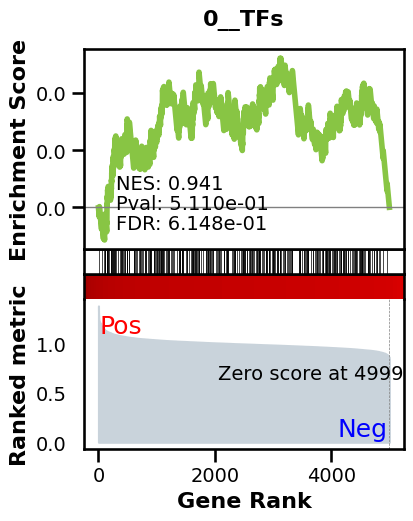

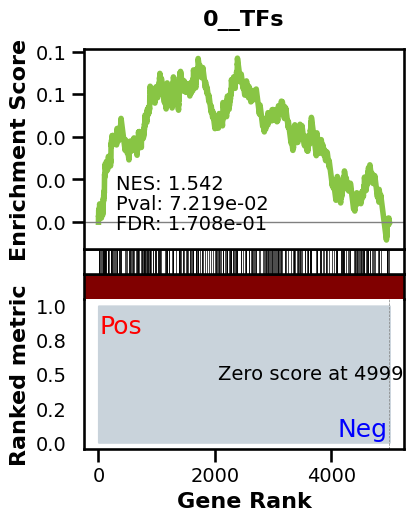

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3565 genes
intersection pct: 0.713
precision:  0.0010619058203785046 
recall:  1.0 
random precision: 0.001062203773751226



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 55.90it/s]


  9%|▉         | 12/128 [00:00<00:02, 55.86it/s]


 14%|█▍        | 18/128 [00:00<00:01, 55.65it/s]


 19%|█▉        | 24/128 [00:00<00:01, 55.73it/s]


 23%|██▎       | 30/128 [00:00<00:01, 55.71it/s]


 28%|██▊       | 36/128 [00:00<00:01, 55.75it/s]


 33%|███▎      | 42/128 [00:00<00:01, 55.77it/s]


 38%|███▊      | 48/128 [00:00<00:01, 55.75it/s]


 42%|████▏     | 54/128 [00:00<00:01, 55.81it/s]


 47%|████▋     | 60/128 [00:01<00:01, 55.81it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 55.73it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 55.78it/s]


 61%|██████    | 78/128 [00:01<00:00, 55.82it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 55.82it/s]


 70%|███████   | 90/128 [00:01<00:00, 55.81it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 55.79it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 55.74it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 55.78it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 55.79it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 55.73it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 55.75it/s]


100%|██████████| 128/128 [00:02<00:00, 55.75it/s]

Average Precision (AP):  0.0011257111456192922
Area Under Precision-Recall Curve (AUPRC):  0.001124845113699537


EPR: 0.41802397075284603


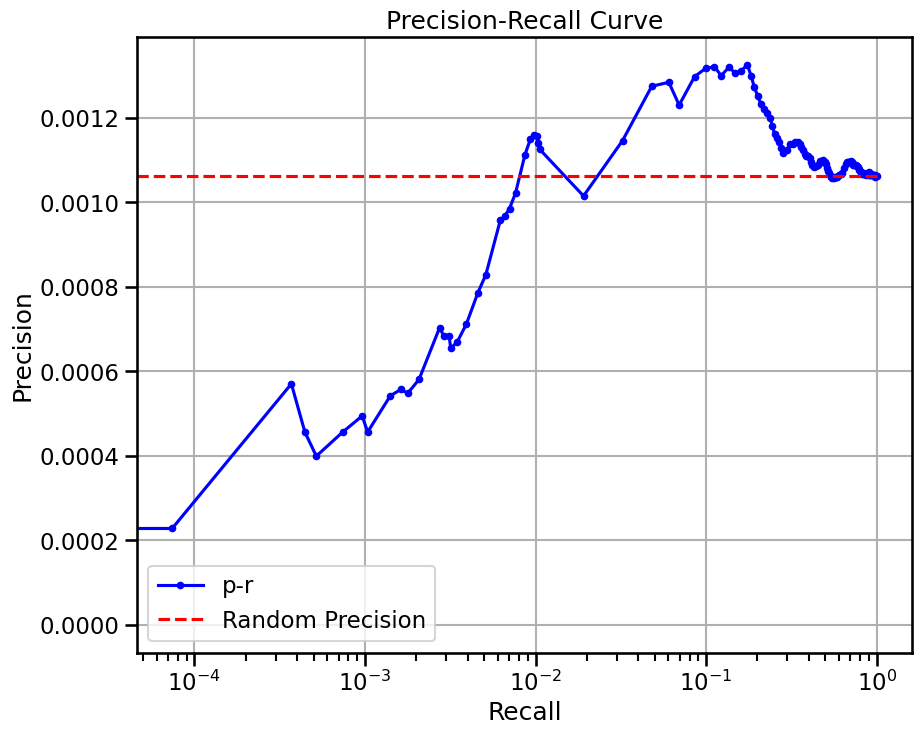

base enrichment


Top central genes: []


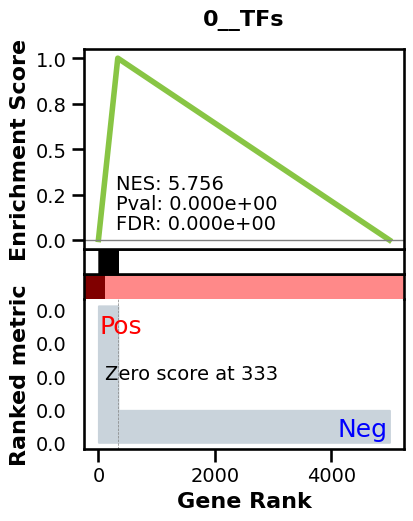

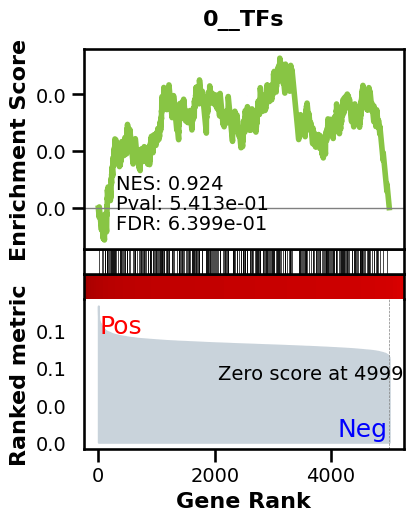

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3565 genes
intersection pct: 0.713
precision:  0.004536165097174915 
recall:  0.33550681683461764 
random precision: 0.001062203773751226



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 54.68it/s]


  9%|▉         | 12/128 [00:00<00:02, 53.88it/s]


 14%|█▍        | 18/128 [00:00<00:02, 53.67it/s]


 19%|█▉        | 24/128 [00:00<00:01, 53.56it/s]


 23%|██▎       | 30/128 [00:00<00:01, 53.43it/s]


 28%|██▊       | 36/128 [00:00<00:01, 53.35it/s]


 33%|███▎      | 42/128 [00:00<00:01, 53.37it/s]


 38%|███▊      | 48/128 [00:00<00:01, 53.38it/s]


 42%|████▏     | 54/128 [00:01<00:01, 53.39it/s]


 47%|████▋     | 60/128 [00:01<00:01, 53.39it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 53.16it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 53.21it/s]


 61%|██████    | 78/128 [00:01<00:00, 53.17it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 53.24it/s]


 70%|███████   | 90/128 [00:01<00:00, 53.25it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 53.28it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 53.37it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 53.37it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 53.39it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 53.40it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 53.43it/s]


100%|██████████| 128/128 [00:02<00:00, 53.37it/s]

Average Precision (AP):  0.002708015469179727
Area Under Precision-Recall Curve (AUPRC):  0.002396776443640568


EPR: 5.492819515439013


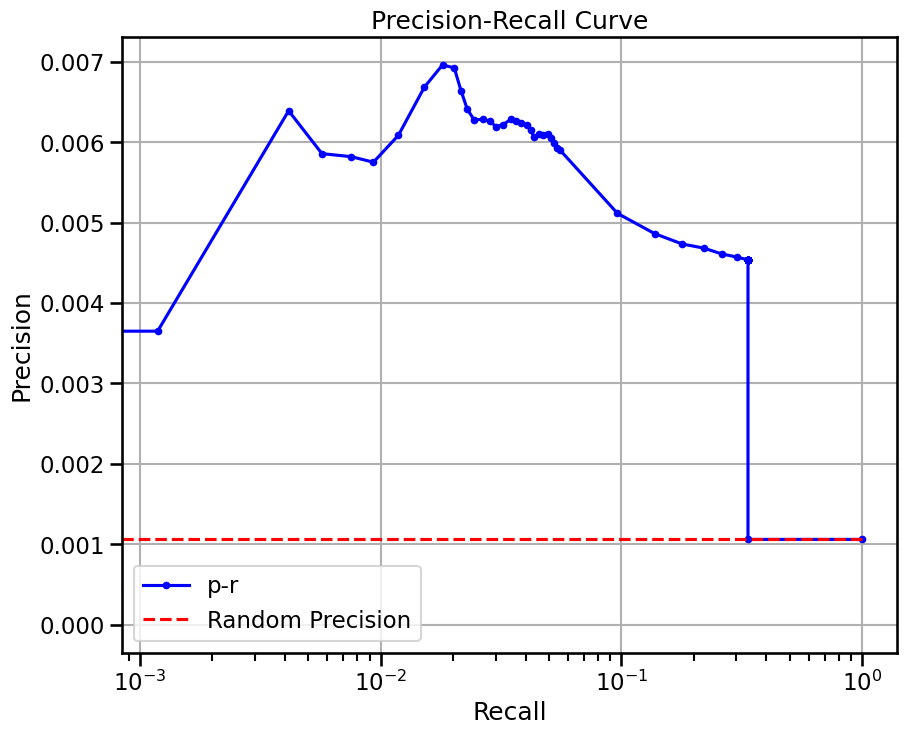

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/26 [00:00<?, ?it/s]


  4%|▍         | 1/26 [00:01<00:36,  1.47s/it]


  8%|▊         | 2/26 [00:02<00:34,  1.45s/it]


 12%|█▏        | 3/26 [00:04<00:33,  1.45s/it]


 15%|█▌        | 4/26 [00:05<00:31,  1.45s/it]


 19%|█▉        | 5/26 [00:07<00:30,  1.44s/it]


 23%|██▎       | 6/26 [00:08<00:28,  1.44s/it]


 27%|██▋       | 7/26 [00:10<00:27,  1.44s/it]


 31%|███       | 8/26 [00:11<00:26,  1.45s/it]


 35%|███▍      | 9/26 [00:13<00:24,  1.45s/it]


 38%|███▊      | 10/26 [00:14<00:23,  1.44s/it]


 42%|████▏     | 11/26 [00:15<00:21,  1.45s/it]


 46%|████▌     | 12/26 [00:17<00:20,  1.45s/it]


 50%|█████     | 13/26 [00:18<00:18,  1.45s/it]


 54%|█████▍    | 14/26 [00:20<00:17,  1.45s/it]


 58%|█████▊    | 15/26 [00:21<00:15,  1.45s/it]


 62%|██████▏   | 16/26 [00:23<00:14,  1.45s/it]


 65%|██████▌   | 17/26 [00:24<00:12,  1.43s/it]


 69%|██████▉   | 18/26 [00:25<00:11,  1.41s/it]


 73%|███████▎  | 19/26 [00:27<00:09,  1.42s/it]


 77%|███████▋  | 20/26 [00:28<00:08,  1.42s/it]


 81%|████████  | 21/26 [00:30<00:07,  1.43s/it]


 85%|████████▍ | 22/26 [00:31<00:05,  1.43s/it]


 88%|████████▊ | 23/26 [00:33<00:04,  1.43s/it]


 92%|█████████▏| 24/26 [00:34<00:02,  1.43s/it]


 96%|█████████▌| 25/26 [00:35<00:01,  1.42s/it]


100%|██████████| 26/26 [00:37<00:00,  1.42s/it]


100%|██████████| 26/26 [00:37<00:00,  1.44s/it]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


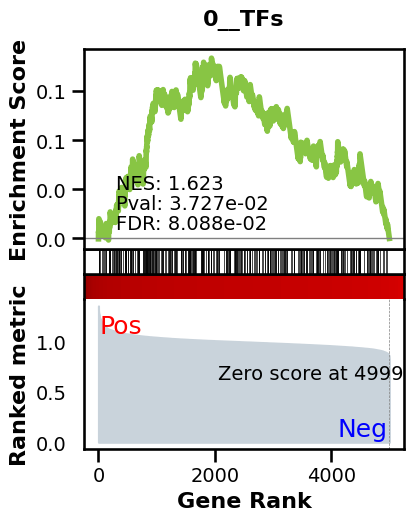

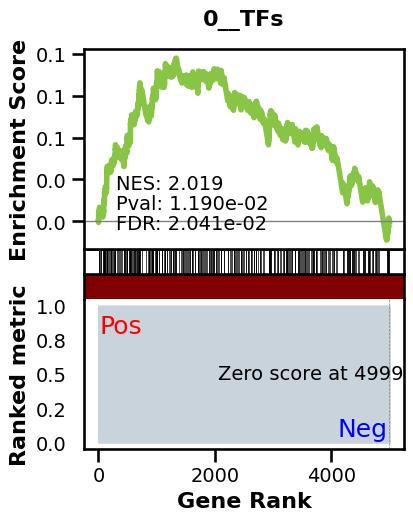

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3514 genes
intersection pct: 0.7028
precision:  0.0012117559520435212 
recall:  1.0 
random precision: 0.0012121008868434197



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 58.16it/s]


  9%|▉         | 12/128 [00:00<00:01, 58.01it/s]


 14%|█▍        | 18/128 [00:00<00:01, 57.97it/s]


 19%|█▉        | 24/128 [00:00<00:01, 57.97it/s]


 23%|██▎       | 30/128 [00:00<00:01, 57.99it/s]


 28%|██▊       | 36/128 [00:00<00:01, 57.94it/s]


 33%|███▎      | 42/128 [00:00<00:01, 57.93it/s]


 38%|███▊      | 48/128 [00:00<00:01, 57.90it/s]


 42%|████▏     | 54/128 [00:00<00:01, 57.56it/s]


 47%|████▋     | 60/128 [00:01<00:01, 57.28it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 57.20it/s]


 56%|█████▋    | 72/128 [00:01<00:00, 57.34it/s]


 61%|██████    | 78/128 [00:01<00:00, 57.18it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 57.16it/s]


 70%|███████   | 90/128 [00:01<00:00, 57.44it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 57.78it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 57.98it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 58.14it/s]


 89%|████████▉ | 114/128 [00:01<00:00, 58.19it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 58.22it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 58.04it/s]


100%|██████████| 128/128 [00:02<00:00, 57.77it/s]

Average Precision (AP):  0.00136134313673798
Area Under Precision-Recall Curve (AUPRC):  0.0013591142112962737
EPR: 1.6012993890227847


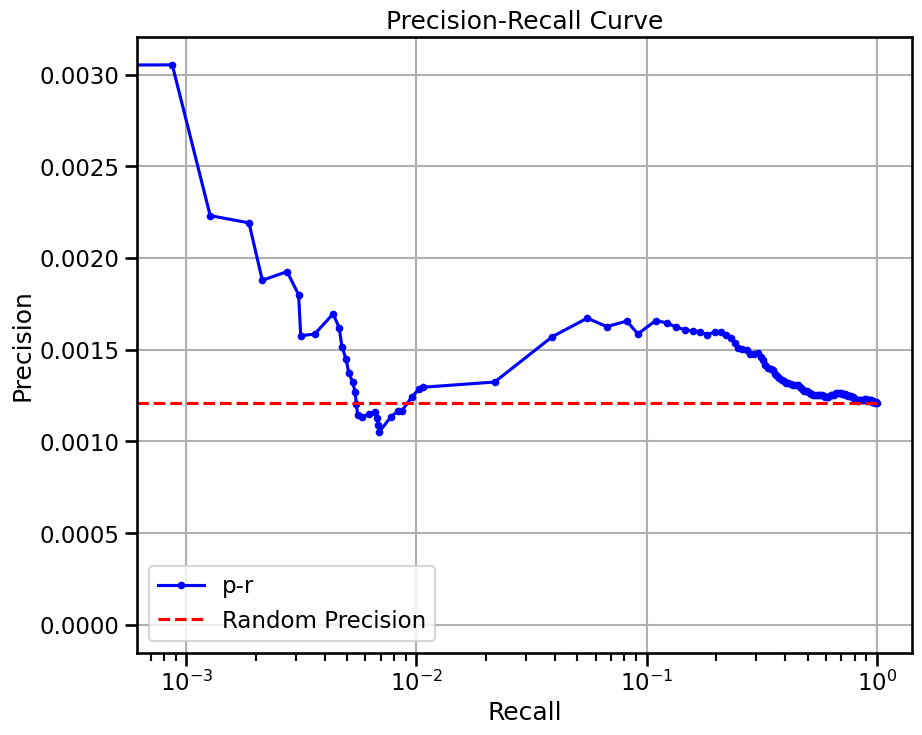

base enrichment


Top central genes: []


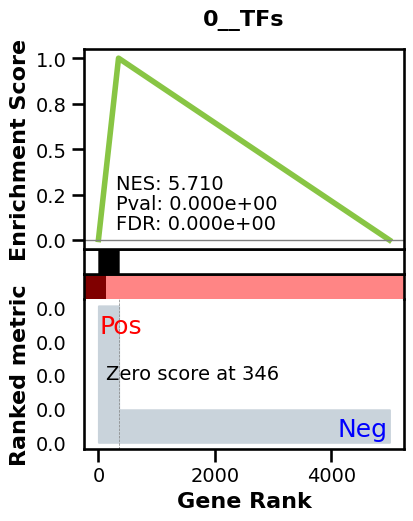

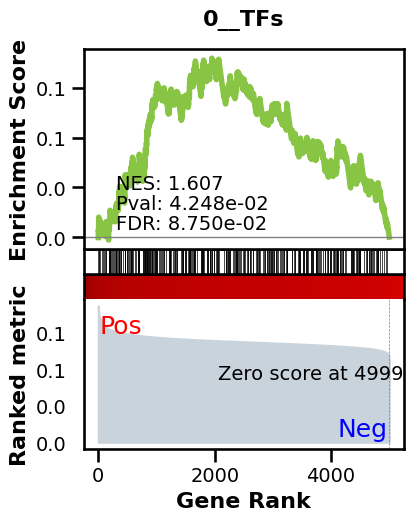

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3514 genes
intersection pct: 0.7028
precision:  0.006066211345095807 
recall:  0.4273875559713961 
random precision: 0.0012121008868434197



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 53.53it/s]


  9%|▉         | 12/128 [00:00<00:02, 52.71it/s]


 14%|█▍        | 18/128 [00:00<00:02, 52.88it/s]


 19%|█▉        | 24/128 [00:00<00:01, 53.02it/s]


 23%|██▎       | 30/128 [00:00<00:01, 53.45it/s]


 28%|██▊       | 36/128 [00:00<00:01, 53.49it/s]


 33%|███▎      | 42/128 [00:00<00:01, 53.38it/s]


 38%|███▊      | 48/128 [00:00<00:01, 52.96it/s]


 42%|████▏     | 54/128 [00:01<00:01, 52.94it/s]


 47%|████▋     | 60/128 [00:01<00:01, 53.06it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 53.40it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 54.00it/s]


 61%|██████    | 78/128 [00:01<00:00, 54.49it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 55.02it/s]


 70%|███████   | 90/128 [00:01<00:00, 55.44it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 55.74it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 56.01it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 56.15it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 56.28it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 55.91it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 56.23it/s]


100%|██████████| 128/128 [00:02<00:00, 54.60it/s]

Average Precision (AP):  0.004210018642187345
Area Under Precision-Recall Curve (AUPRC):  0.003708750811688975
EPR: 7.504324491961298


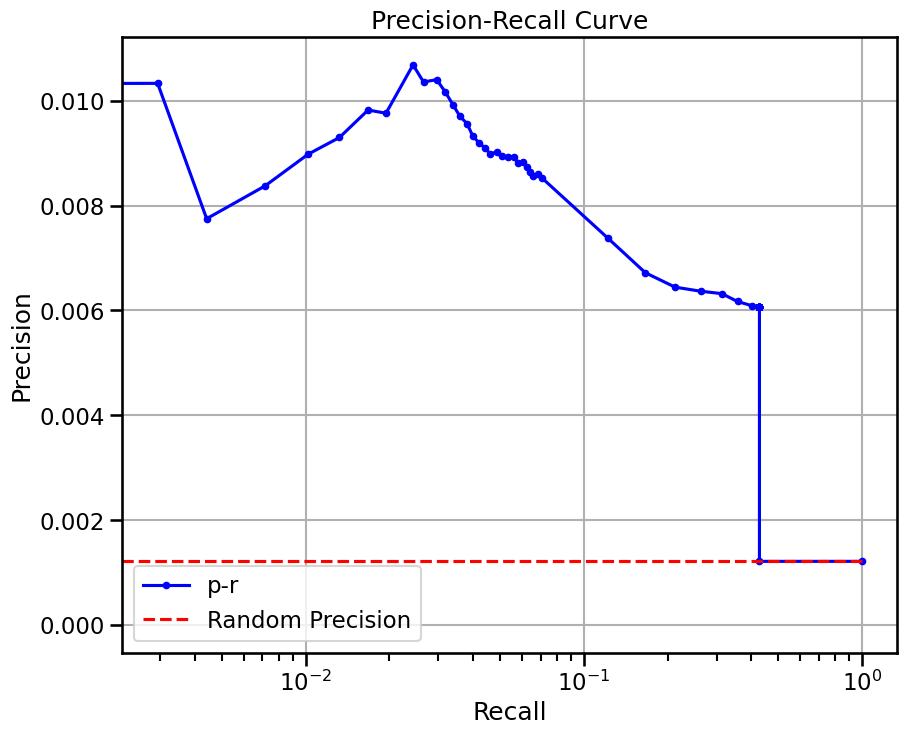

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/35 [00:00<?, ?it/s]


  3%|▎         | 1/35 [00:01<00:46,  1.36s/it]


  6%|▌         | 2/35 [00:02<00:44,  1.36s/it]


  9%|▊         | 3/35 [00:04<00:43,  1.37s/it]


 11%|█▏        | 4/35 [00:05<00:42,  1.37s/it]


 14%|█▍        | 5/35 [00:06<00:41,  1.37s/it]


 17%|█▋        | 6/35 [00:08<00:39,  1.37s/it]


 20%|██        | 7/35 [00:09<00:38,  1.37s/it]


 23%|██▎       | 8/35 [00:10<00:37,  1.37s/it]


 26%|██▌       | 9/35 [00:12<00:35,  1.37s/it]


 29%|██▊       | 10/35 [00:13<00:34,  1.38s/it]


 31%|███▏      | 11/35 [00:15<00:33,  1.38s/it]


 34%|███▍      | 12/35 [00:16<00:31,  1.37s/it]


 37%|███▋      | 13/35 [00:17<00:30,  1.38s/it]


 40%|████      | 14/35 [00:19<00:28,  1.38s/it]


 43%|████▎     | 15/35 [00:20<00:27,  1.38s/it]


 46%|████▌     | 16/35 [00:21<00:26,  1.38s/it]


 49%|████▊     | 17/35 [00:23<00:24,  1.38s/it]


 51%|█████▏    | 18/35 [00:24<00:23,  1.38s/it]


 54%|█████▍    | 19/35 [00:26<00:22,  1.38s/it]


 57%|█████▋    | 20/35 [00:27<00:20,  1.39s/it]


 60%|██████    | 21/35 [00:28<00:19,  1.39s/it]


 63%|██████▎   | 22/35 [00:30<00:18,  1.39s/it]


 66%|██████▌   | 23/35 [00:31<00:16,  1.40s/it]


 69%|██████▊   | 24/35 [00:33<00:15,  1.40s/it]


 71%|███████▏  | 25/35 [00:34<00:13,  1.39s/it]


 74%|███████▍  | 26/35 [00:35<00:12,  1.39s/it]


 77%|███████▋  | 27/35 [00:37<00:11,  1.40s/it]


 80%|████████  | 28/35 [00:38<00:09,  1.40s/it]


 83%|████████▎ | 29/35 [00:40<00:08,  1.40s/it]


 86%|████████▌ | 30/35 [00:41<00:06,  1.40s/it]


 89%|████████▊ | 31/35 [00:42<00:05,  1.41s/it]


 91%|█████████▏| 32/35 [00:44<00:04,  1.41s/it]


 94%|█████████▍| 33/35 [00:45<00:02,  1.43s/it]


 97%|█████████▋| 34/35 [00:47<00:01,  1.42s/it]


100%|██████████| 35/35 [00:48<00:00,  1.28s/it]


100%|██████████| 35/35 [00:48<00:00,  1.38s/it]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


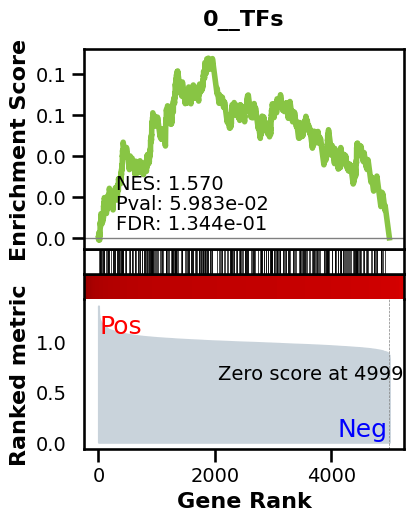

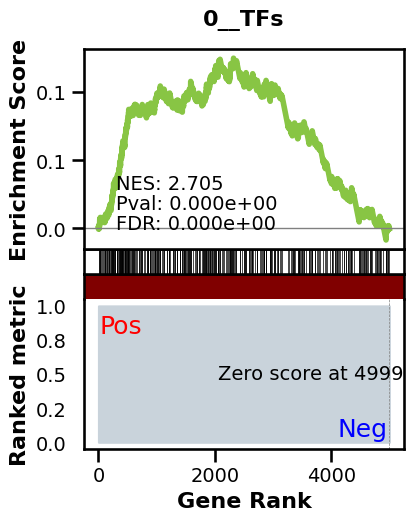

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3594 genes
intersection pct: 0.7188
precision:  0.0013615563439839291 
recall:  1.0 
random precision: 0.0013619352909207464



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 52.81it/s]


  9%|▉         | 12/128 [00:00<00:02, 52.93it/s]


 14%|█▍        | 18/128 [00:00<00:02, 52.77it/s]


 19%|█▉        | 24/128 [00:00<00:01, 52.73it/s]


 23%|██▎       | 30/128 [00:00<00:01, 52.52it/s]


 28%|██▊       | 36/128 [00:00<00:01, 52.25it/s]


 33%|███▎      | 42/128 [00:00<00:01, 52.33it/s]


 38%|███▊      | 48/128 [00:00<00:01, 52.56it/s]


 42%|████▏     | 54/128 [00:01<00:01, 52.69it/s]


 47%|████▋     | 60/128 [00:01<00:01, 52.72it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 52.61it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 52.45it/s]


 61%|██████    | 78/128 [00:01<00:00, 52.21it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 52.23it/s]


 70%|███████   | 90/128 [00:01<00:00, 52.44it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 52.60it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 52.70it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 52.48it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 52.61it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 52.28it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 52.30it/s]


100%|██████████| 128/128 [00:02<00:00, 52.47it/s]

Average Precision (AP):  0.0016245115492951204
Area Under Precision-Recall Curve (AUPRC):  0.00162132046476463
EPR: 0.667387823531448


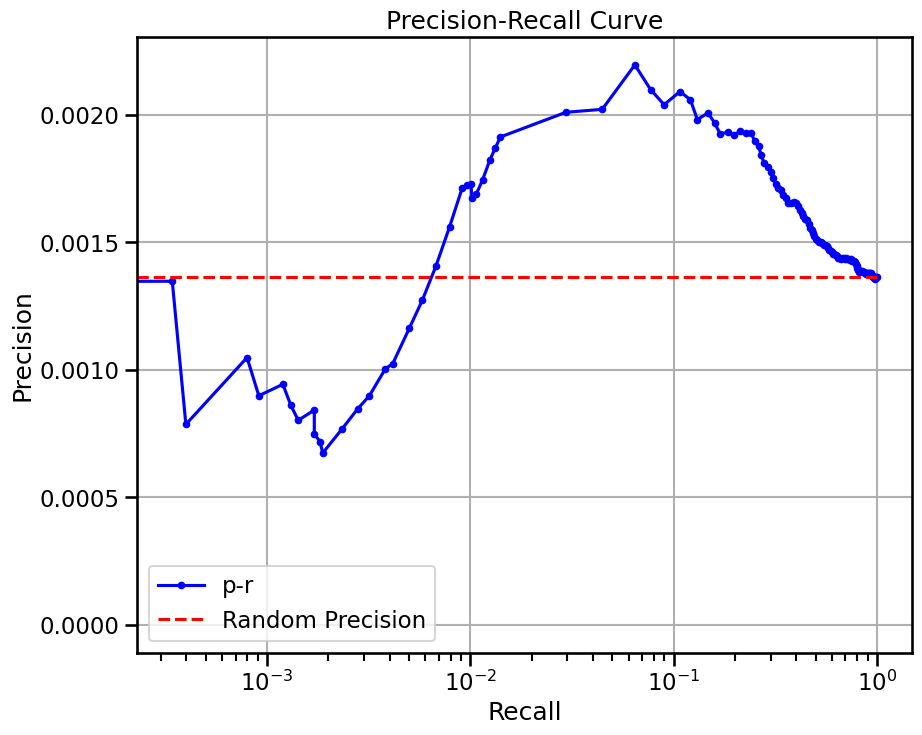

base enrichment


Top central genes: []


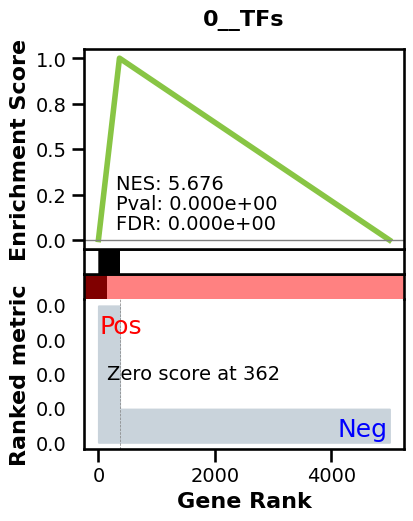

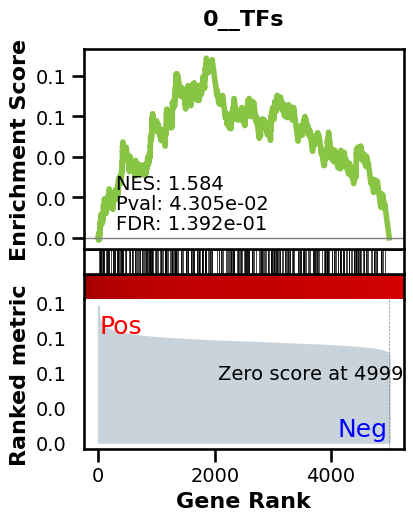

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3594 genes
intersection pct: 0.7188
precision:  0.0069836836322646 
recall:  0.4452720759652016 
random precision: 0.0013619352909207464



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 52.74it/s]


  9%|▉         | 12/128 [00:00<00:02, 52.68it/s]


 14%|█▍        | 18/128 [00:00<00:02, 52.76it/s]


 19%|█▉        | 24/128 [00:00<00:01, 52.62it/s]


 23%|██▎       | 30/128 [00:00<00:01, 52.57it/s]


 28%|██▊       | 36/128 [00:00<00:01, 52.44it/s]


 33%|███▎      | 42/128 [00:00<00:01, 52.42it/s]


 38%|███▊      | 48/128 [00:00<00:01, 52.47it/s]


 42%|████▏     | 54/128 [00:01<00:01, 52.60it/s]


 47%|████▋     | 60/128 [00:01<00:01, 52.72it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 52.76it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 52.64it/s]


 61%|██████    | 78/128 [00:01<00:00, 52.67it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 52.75it/s]


 70%|███████   | 90/128 [00:01<00:00, 52.81it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 52.75it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 52.79it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 52.81it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 52.84it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 52.78it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 52.78it/s]


100%|██████████| 128/128 [00:02<00:00, 52.68it/s]

Average Precision (AP):  0.005326114122453475
Area Under Precision-Recall Curve (AUPRC):  0.004798383641358179
EPR: 8.95627640959181


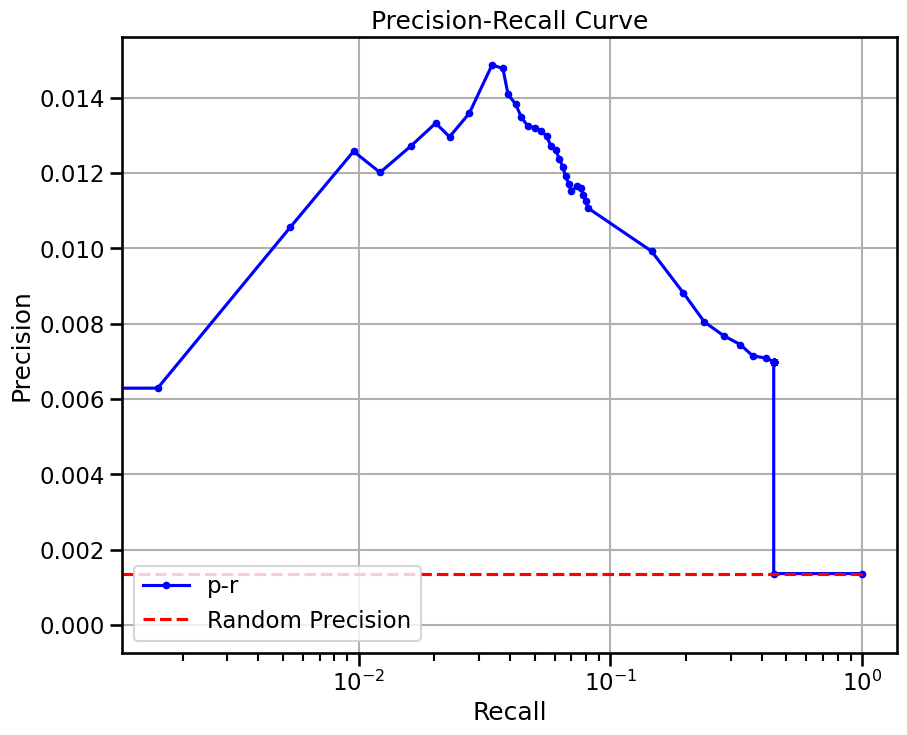

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/22 [00:00<?, ?it/s]


  5%|▍         | 1/22 [00:00<00:12,  1.70it/s]


  9%|▉         | 2/22 [00:01<00:11,  1.69it/s]


 14%|█▎        | 3/22 [00:01<00:11,  1.69it/s]


 18%|█▊        | 4/22 [00:02<00:10,  1.69it/s]


 23%|██▎       | 5/22 [00:02<00:10,  1.69it/s]


 27%|██▋       | 6/22 [00:03<00:09,  1.69it/s]


 32%|███▏      | 7/22 [00:04<00:08,  1.69it/s]


 36%|███▋      | 8/22 [00:04<00:08,  1.69it/s]


 41%|████      | 9/22 [00:05<00:07,  1.69it/s]


 45%|████▌     | 10/22 [00:05<00:07,  1.69it/s]


 50%|█████     | 11/22 [00:06<00:06,  1.69it/s]


 55%|█████▍    | 12/22 [00:07<00:05,  1.69it/s]


 59%|█████▉    | 13/22 [00:07<00:05,  1.69it/s]


 64%|██████▎   | 14/22 [00:08<00:04,  1.69it/s]


 68%|██████▊   | 15/22 [00:08<00:04,  1.69it/s]


 73%|███████▎  | 16/22 [00:09<00:03,  1.68it/s]


 77%|███████▋  | 17/22 [00:10<00:02,  1.68it/s]


 82%|████████▏ | 18/22 [00:10<00:02,  1.68it/s]


 86%|████████▋ | 19/22 [00:11<00:01,  1.68it/s]


 91%|█████████ | 20/22 [00:11<00:01,  1.68it/s]


 95%|█████████▌| 21/22 [00:12<00:00,  1.69it/s]


100%|██████████| 22/22 [00:12<00:00,  1.73it/s]


100%|██████████| 22/22 [00:12<00:00,  1.69it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


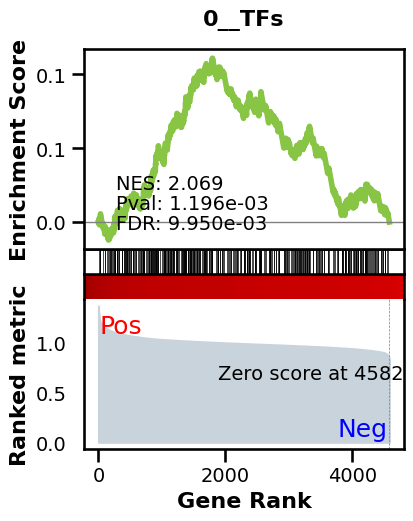

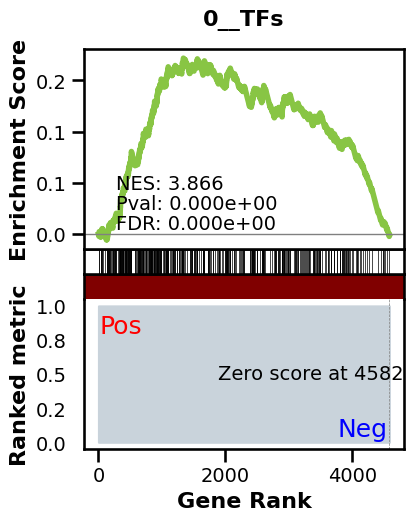

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3353 genes
intersection pct: 0.7316168448614445
precision:  0.0017709412468226904 
recall:  1.0 
random precision: 0.0017714695705836757



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▌         | 7/128 [00:00<00:01, 60.80it/s]


 11%|█         | 14/128 [00:00<00:01, 60.43it/s]


 16%|█▋        | 21/128 [00:00<00:01, 60.62it/s]


 22%|██▏       | 28/128 [00:00<00:01, 60.79it/s]


 27%|██▋       | 35/128 [00:00<00:01, 60.93it/s]


 33%|███▎      | 42/128 [00:00<00:01, 61.00it/s]


 38%|███▊      | 49/128 [00:00<00:01, 60.99it/s]


 44%|████▍     | 56/128 [00:00<00:01, 61.07it/s]


 49%|████▉     | 63/128 [00:01<00:01, 60.80it/s]


 55%|█████▍    | 70/128 [00:01<00:00, 60.85it/s]


 60%|██████    | 77/128 [00:01<00:00, 60.85it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 60.90it/s]


 71%|███████   | 91/128 [00:01<00:00, 60.45it/s]


 77%|███████▋  | 98/128 [00:01<00:00, 60.31it/s]


 82%|████████▏ | 105/128 [00:01<00:00, 60.53it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 60.71it/s]


 93%|█████████▎| 119/128 [00:01<00:00, 60.81it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 60.64it/s]


100%|██████████| 128/128 [00:02<00:00, 60.71it/s]

Average Precision (AP):  0.0019507780134439372
Area Under Precision-Recall Curve (AUPRC):  0.0019492044171959123
EPR: 1.8770861723661858


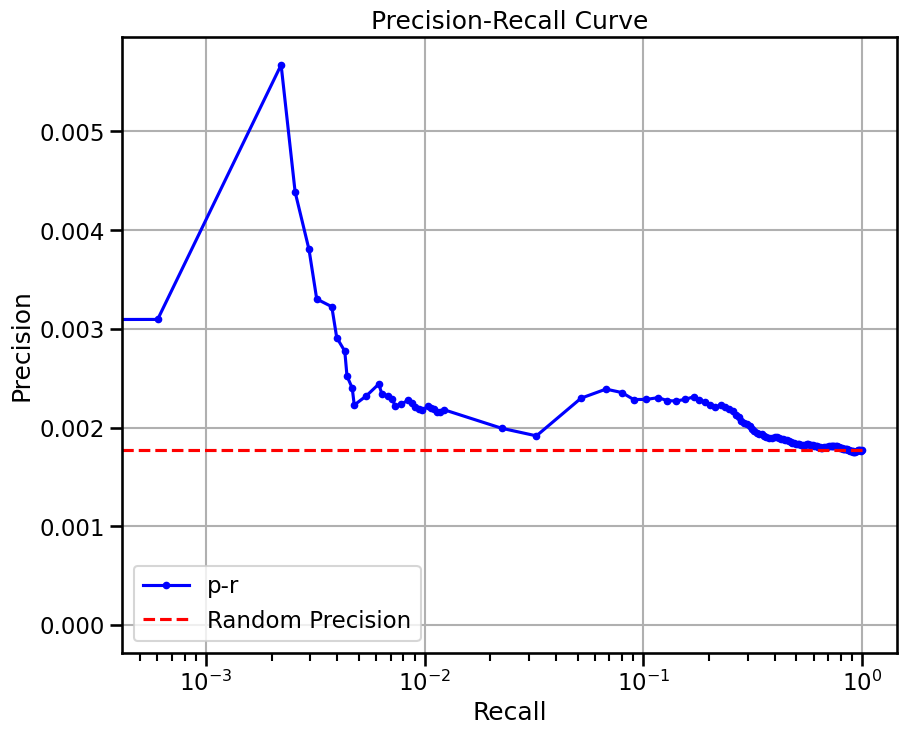

base enrichment


Top central genes: []


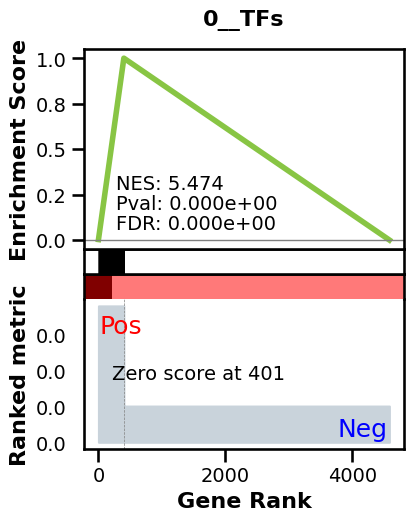

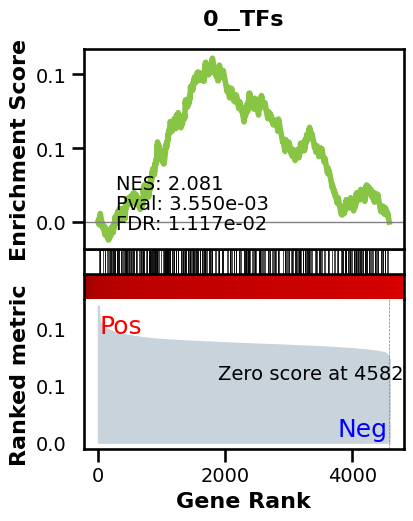

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3353 genes
intersection pct: 0.7316168448614445
precision:  0.008408052656457818 
recall:  0.5083375188347564 
random precision: 0.0017714695705836757



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▌         | 7/128 [00:00<00:01, 60.98it/s]


 11%|█         | 14/128 [00:00<00:01, 60.92it/s]


 16%|█▋        | 21/128 [00:00<00:01, 61.22it/s]


 22%|██▏       | 28/128 [00:00<00:01, 61.10it/s]


 27%|██▋       | 35/128 [00:00<00:01, 61.21it/s]


 33%|███▎      | 42/128 [00:00<00:01, 61.21it/s]


 38%|███▊      | 49/128 [00:00<00:01, 61.42it/s]


 44%|████▍     | 56/128 [00:00<00:01, 61.46it/s]


 49%|████▉     | 63/128 [00:01<00:01, 61.40it/s]


 55%|█████▍    | 70/128 [00:01<00:00, 61.41it/s]


 60%|██████    | 77/128 [00:01<00:00, 61.43it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 61.43it/s]


 71%|███████   | 91/128 [00:01<00:00, 61.33it/s]


 77%|███████▋  | 98/128 [00:01<00:00, 61.49it/s]


 82%|████████▏ | 105/128 [00:01<00:00, 61.51it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 61.33it/s]


 93%|█████████▎| 119/128 [00:01<00:00, 61.35it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 61.52it/s]


100%|██████████| 128/128 [00:02<00:00, 61.35it/s]

Average Precision (AP):  0.00651337192038818
Area Under Precision-Recall Curve (AUPRC):  0.0059029076982775154
EPR: 6.532608663334661


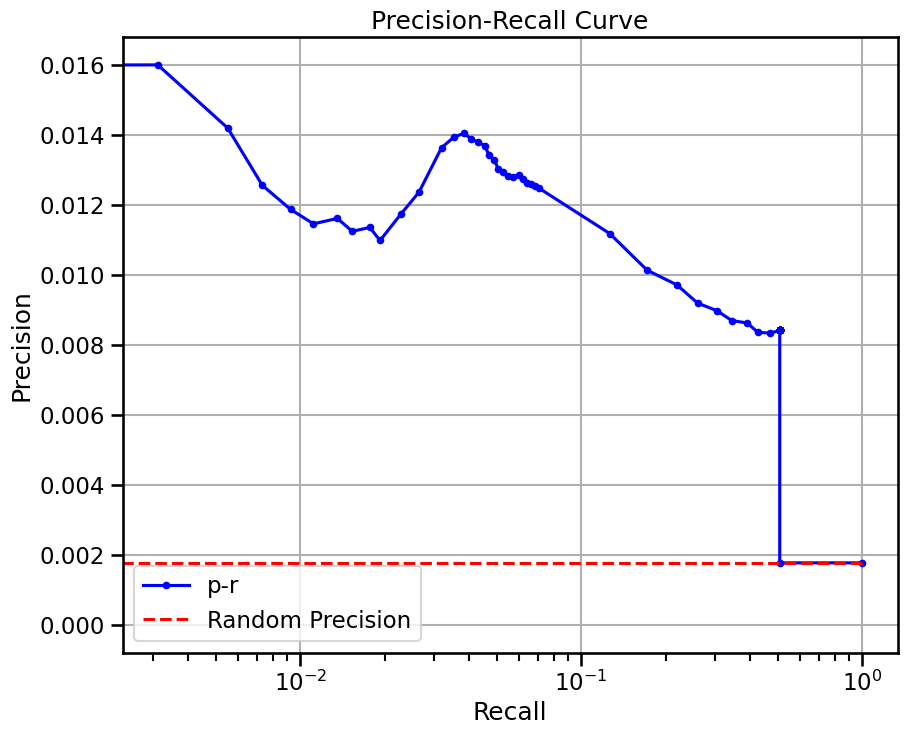

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/36 [00:00<?, ?it/s]


  3%|▎         | 1/36 [00:01<00:49,  1.40s/it]


  6%|▌         | 2/36 [00:02<00:48,  1.43s/it]


  8%|▊         | 3/36 [00:04<00:47,  1.44s/it]


 11%|█         | 4/36 [00:05<00:46,  1.44s/it]


 14%|█▍        | 5/36 [00:07<00:44,  1.44s/it]


 17%|█▋        | 6/36 [00:08<00:43,  1.44s/it]


 19%|█▉        | 7/36 [00:10<00:41,  1.44s/it]


 22%|██▏       | 8/36 [00:11<00:40,  1.45s/it]


 25%|██▌       | 9/36 [00:12<00:39,  1.45s/it]


 28%|██▊       | 10/36 [00:14<00:37,  1.45s/it]


 31%|███       | 11/36 [00:15<00:36,  1.45s/it]


 33%|███▎      | 12/36 [00:17<00:34,  1.45s/it]


 36%|███▌      | 13/36 [00:18<00:33,  1.45s/it]


 39%|███▉      | 14/36 [00:20<00:32,  1.46s/it]


 42%|████▏     | 15/36 [00:21<00:30,  1.46s/it]


 44%|████▍     | 16/36 [00:23<00:29,  1.45s/it]


 47%|████▋     | 17/36 [00:24<00:27,  1.45s/it]


 50%|█████     | 18/36 [00:26<00:26,  1.45s/it]


 53%|█████▎    | 19/36 [00:27<00:24,  1.46s/it]


 56%|█████▌    | 20/36 [00:28<00:22,  1.43s/it]


 58%|█████▊    | 21/36 [00:30<00:21,  1.44s/it]


 61%|██████    | 22/36 [00:31<00:20,  1.44s/it]


 64%|██████▍   | 23/36 [00:33<00:18,  1.45s/it]


 67%|██████▋   | 24/36 [00:34<00:17,  1.45s/it]


 69%|██████▉   | 25/36 [00:36<00:15,  1.45s/it]


 72%|███████▏  | 26/36 [00:37<00:14,  1.45s/it]


 75%|███████▌  | 27/36 [00:39<00:13,  1.45s/it]


 78%|███████▊  | 28/36 [00:40<00:11,  1.46s/it]


 81%|████████  | 29/36 [00:42<00:10,  1.46s/it]


 83%|████████▎ | 30/36 [00:43<00:08,  1.46s/it]


 86%|████████▌ | 31/36 [00:44<00:07,  1.47s/it]


 89%|████████▉ | 32/36 [00:46<00:05,  1.47s/it]


 92%|█████████▏| 33/36 [00:47<00:04,  1.47s/it]


 94%|█████████▍| 34/36 [00:49<00:02,  1.46s/it]


 97%|█████████▋| 35/36 [00:50<00:01,  1.46s/it]


100%|██████████| 36/36 [00:51<00:00,  1.09s/it]


100%|██████████| 36/36 [00:51<00:00,  1.42s/it]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


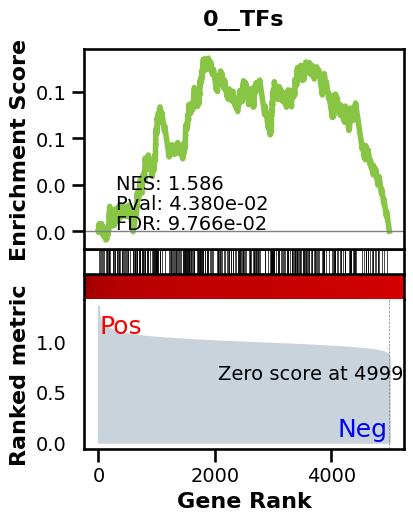

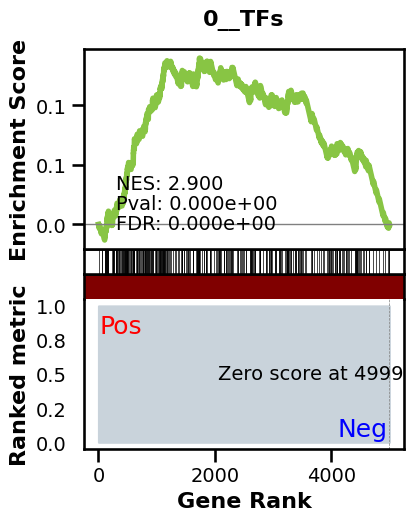

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3603 genes
intersection pct: 0.7206
precision:  0.0015177625516220679 
recall:  1.0 
random precision: 0.001518183918238287



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 51.24it/s]


  9%|▉         | 12/128 [00:00<00:02, 51.47it/s]


 14%|█▍        | 18/128 [00:00<00:02, 51.39it/s]


 19%|█▉        | 24/128 [00:00<00:02, 51.25it/s]


 23%|██▎       | 30/128 [00:00<00:01, 51.39it/s]


 28%|██▊       | 36/128 [00:00<00:01, 51.17it/s]


 33%|███▎      | 42/128 [00:00<00:01, 51.10it/s]


 38%|███▊      | 48/128 [00:00<00:01, 51.04it/s]


 42%|████▏     | 54/128 [00:01<00:01, 51.21it/s]


 47%|████▋     | 60/128 [00:01<00:01, 51.34it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 51.19it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 51.28it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.41it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 51.09it/s]


 70%|███████   | 90/128 [00:01<00:00, 51.03it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 50.91it/s]


 80%|███████▉  | 102/128 [00:01<00:00, 51.03it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 51.12it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 50.96it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 50.97it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 51.24it/s]


100%|██████████| 128/128 [00:02<00:00, 51.16it/s]

Average Precision (AP):  0.0017317206770392454
Area Under Precision-Recall Curve (AUPRC):  0.0017277506420709954
EPR: 1.5403243719011344


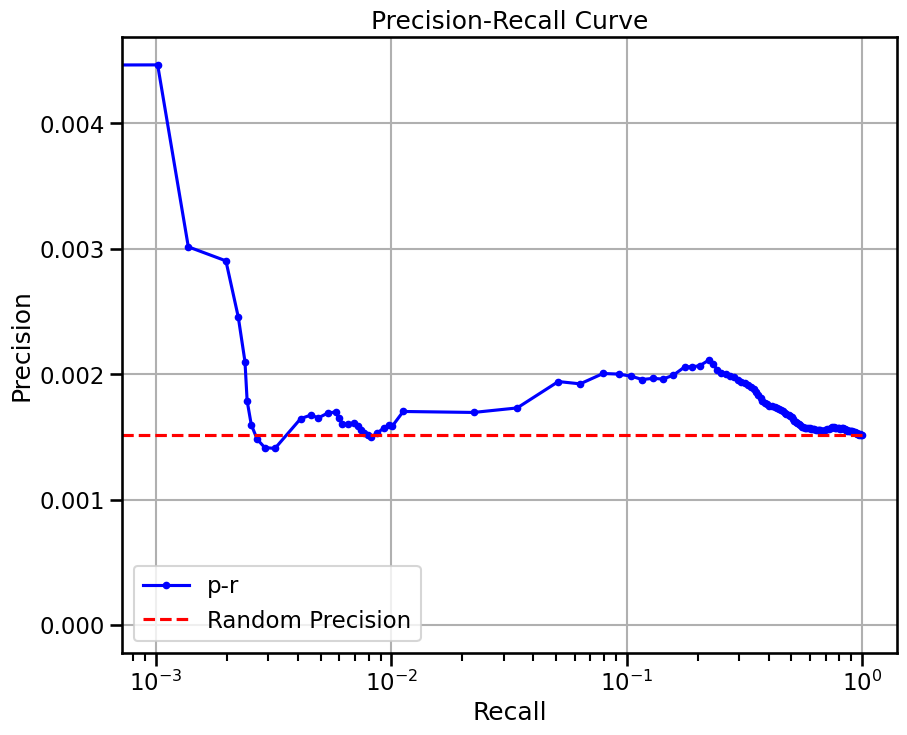

base enrichment


Top central genes: []


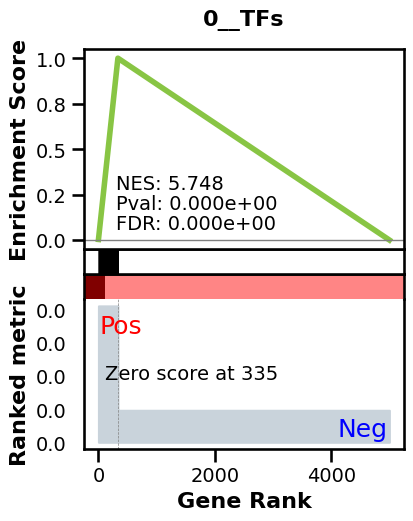

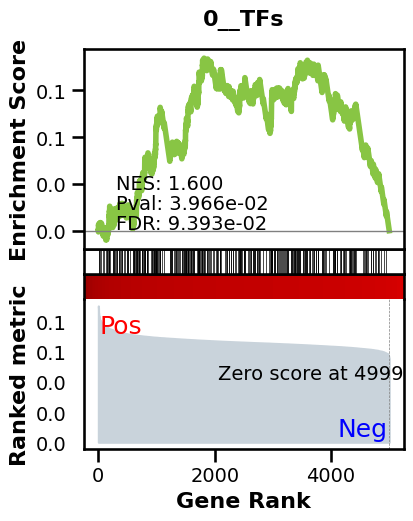

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3603 genes
intersection pct: 0.7206
precision:  0.008506424826158382 
recall:  0.46043749682789425 
random precision: 0.001518183918238287



  0%|          | 0/128 [00:00<?, ?it/s]


  5%|▍         | 6/128 [00:00<00:02, 50.35it/s]


  9%|▉         | 12/128 [00:00<00:02, 50.24it/s]


 14%|█▍        | 18/128 [00:00<00:02, 50.24it/s]


 19%|█▉        | 24/128 [00:00<00:02, 50.26it/s]


 23%|██▎       | 30/128 [00:00<00:01, 50.18it/s]


 28%|██▊       | 36/128 [00:00<00:01, 50.19it/s]


 33%|███▎      | 42/128 [00:00<00:01, 50.01it/s]


 38%|███▊      | 48/128 [00:00<00:01, 50.07it/s]


 42%|████▏     | 54/128 [00:01<00:01, 50.08it/s]


 47%|████▋     | 60/128 [00:01<00:01, 50.28it/s]


 52%|█████▏    | 66/128 [00:01<00:01, 50.77it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 51.20it/s]


 61%|██████    | 78/128 [00:01<00:00, 51.15it/s]


 66%|██████▌   | 84/128 [00:01<00:00, 50.90it/s]


 70%|███████   | 90/128 [00:01<00:00, 50.85it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 50.61it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 50.46it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 50.32it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 50.26it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 50.18it/s]


 98%|█████████▊| 126/128 [00:02<00:00, 50.16it/s]


100%|██████████| 128/128 [00:02<00:00, 50.38it/s]

Average Precision (AP):  0.006186964623755855
Area Under Precision-Recall Curve (AUPRC):  0.005567269991027709
EPR: 7.603643206426641


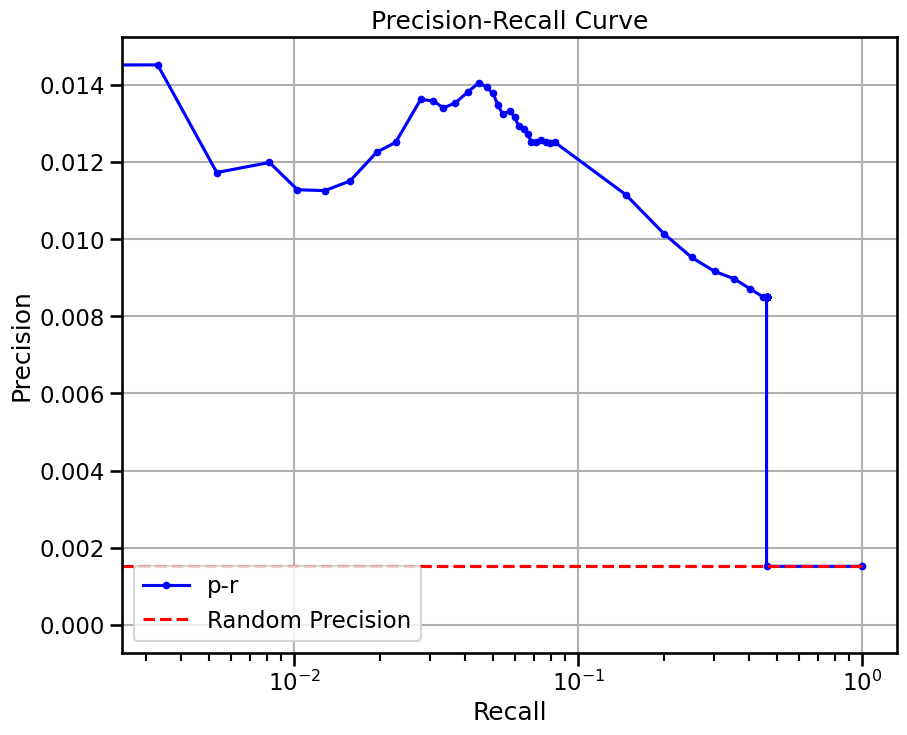

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:00<00:01,  2.67it/s]


 40%|████      | 2/5 [00:00<00:01,  2.78it/s]


 60%|██████    | 3/5 [00:01<00:00,  2.70it/s]


 80%|████████  | 4/5 [00:01<00:00,  2.66it/s]


100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


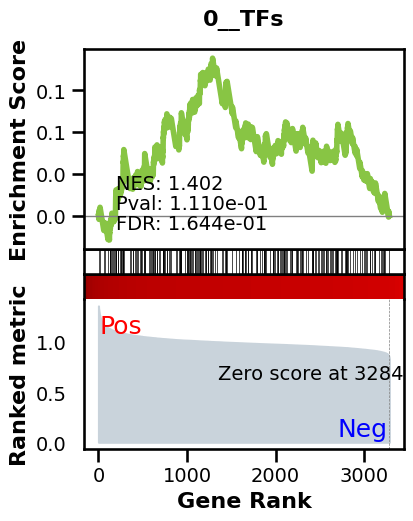

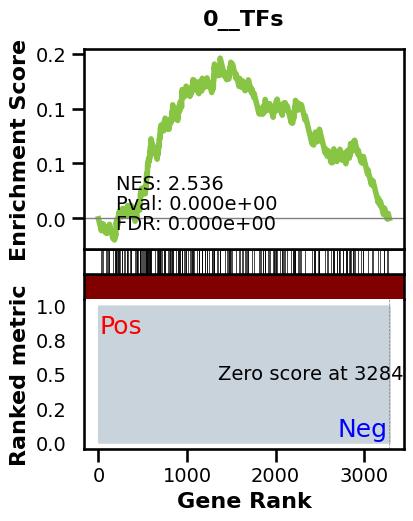

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2395 genes
intersection pct: 0.7290715372907154
precision:  0.0016371964906010696 
recall:  1.0 
random precision: 0.0016378803654927157



  0%|          | 0/128 [00:00<?, ?it/s]


  9%|▉         | 12/128 [00:00<00:00, 118.34it/s]


 19%|█▉        | 24/128 [00:00<00:00, 118.25it/s]


 28%|██▊       | 36/128 [00:00<00:00, 118.62it/s]


 38%|███▊      | 48/128 [00:00<00:00, 118.55it/s]


 47%|████▋     | 60/128 [00:00<00:00, 118.44it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 117.90it/s]


 66%|██████▌   | 84/128 [00:00<00:00, 118.03it/s]


 75%|███████▌  | 96/128 [00:00<00:00, 117.69it/s]


 84%|████████▍ | 108/128 [00:00<00:00, 117.98it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 118.54it/s]


100%|██████████| 128/128 [00:01<00:00, 118.41it/s]

Average Precision (AP):  0.0019214411420839237
Area Under Precision-Recall Curve (AUPRC):  0.0019199697124649877
EPR: 2.41665407199462


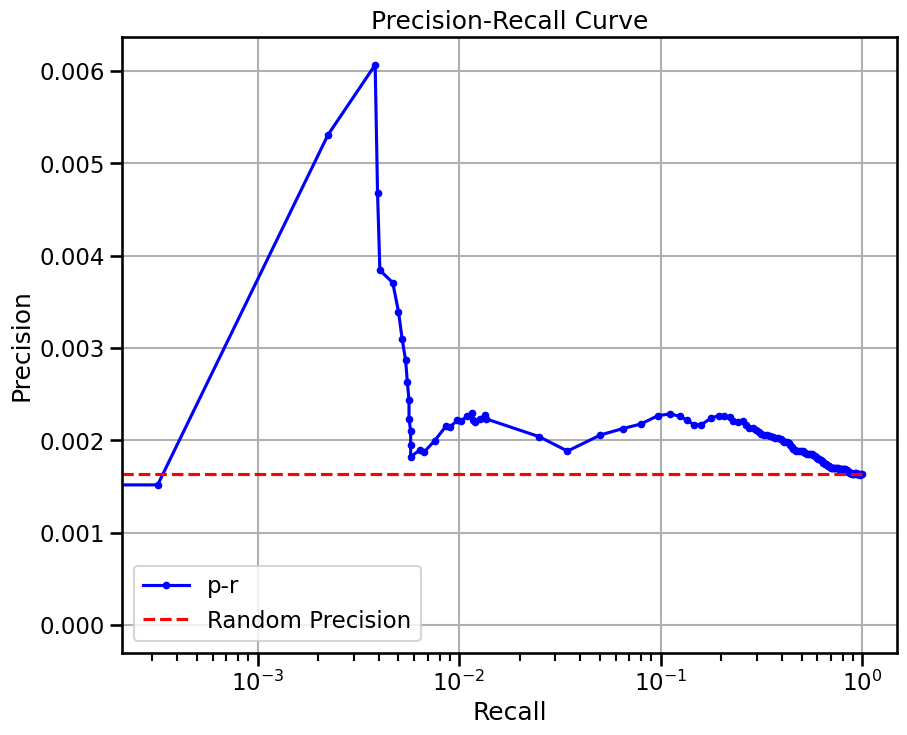

base enrichment


Top central genes: []


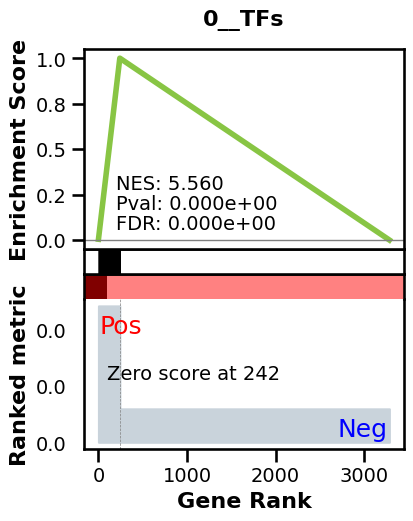

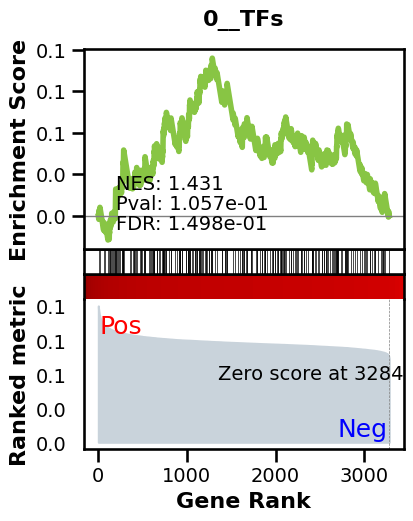

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2395 genes
intersection pct: 0.7290715372907154
precision:  0.008701618199104158 
recall:  0.4726866148439996 
random precision: 0.0016378803654927157



  0%|          | 0/128 [00:00<?, ?it/s]


  9%|▊         | 11/128 [00:00<00:01, 102.42it/s]


 17%|█▋        | 22/128 [00:00<00:01, 103.06it/s]


 26%|██▌       | 33/128 [00:00<00:00, 103.23it/s]


 34%|███▍      | 44/128 [00:00<00:00, 103.37it/s]


 43%|████▎     | 55/128 [00:00<00:00, 103.73it/s]


 52%|█████▏    | 66/128 [00:00<00:00, 104.54it/s]


 60%|██████    | 77/128 [00:00<00:00, 104.63it/s]


 69%|██████▉   | 88/128 [00:00<00:00, 103.57it/s]


 77%|███████▋  | 99/128 [00:00<00:00, 104.04it/s]


 86%|████████▌ | 110/128 [00:01<00:00, 104.44it/s]


 95%|█████████▍| 121/128 [00:01<00:00, 103.05it/s]


100%|██████████| 128/128 [00:01<00:00, 103.46it/s]

Average Precision (AP):  0.007188356718763465
Area Under Precision-Recall Curve (AUPRC):  0.0064490163016745925
EPR: 8.936740303642408


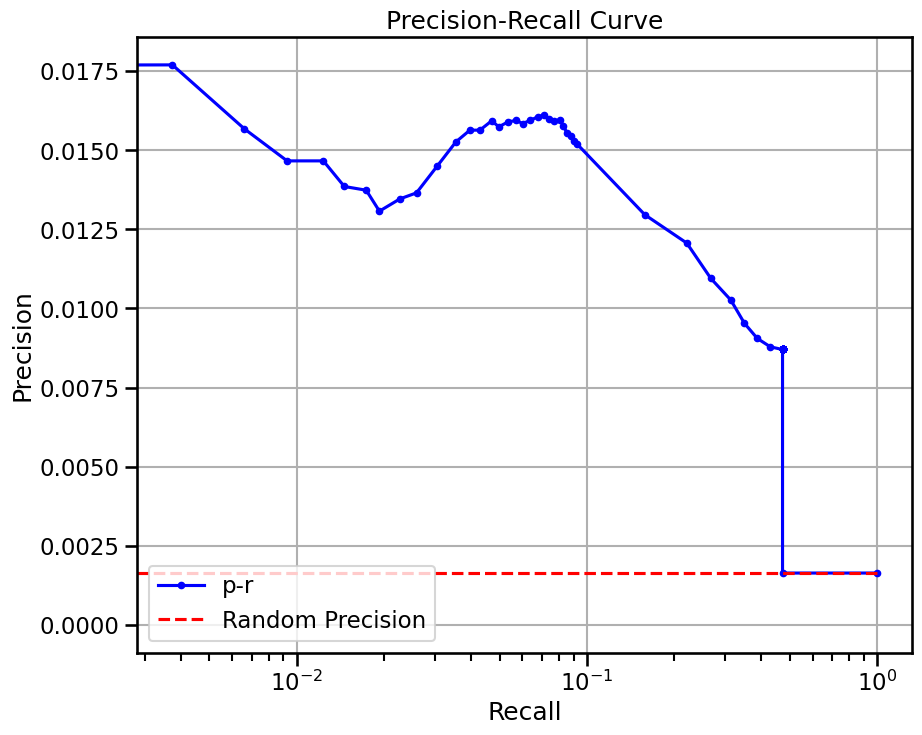

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/26 [00:00<?, ?it/s]


  8%|▊         | 2/26 [00:00<00:02, 11.28it/s]


 15%|█▌        | 4/26 [00:00<00:01, 11.48it/s]


 23%|██▎       | 6/26 [00:00<00:01, 11.50it/s]


 31%|███       | 8/26 [00:00<00:01, 11.56it/s]


 38%|███▊      | 10/26 [00:00<00:01, 11.59it/s]


 46%|████▌     | 12/26 [00:01<00:01, 11.59it/s]


 54%|█████▍    | 14/26 [00:01<00:01, 11.60it/s]


 62%|██████▏   | 16/26 [00:01<00:00, 11.62it/s]


 69%|██████▉   | 18/26 [00:01<00:00, 11.62it/s]


 77%|███████▋  | 20/26 [00:01<00:00, 11.63it/s]


 85%|████████▍ | 22/26 [00:01<00:00, 11.63it/s]


 92%|█████████▏| 24/26 [00:02<00:00, 11.63it/s]


100%|██████████| 26/26 [00:02<00:00, 12.84it/s]


100%|██████████| 26/26 [00:02<00:00, 11.88it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


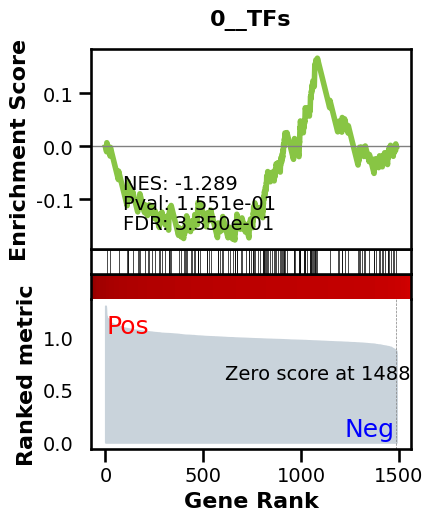

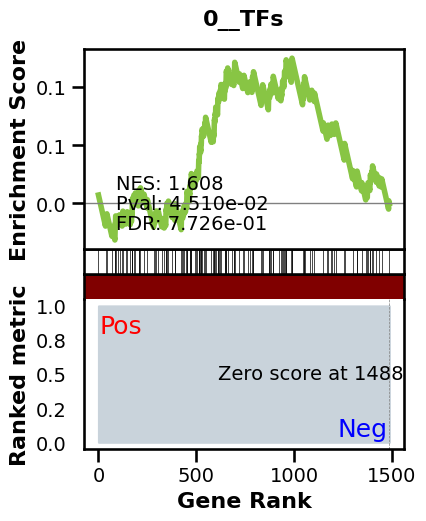

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1050 genes
intersection pct: 0.7051712558764271
precision:  0.0016634920634920635 
recall:  1.0 
random precision: 0.0016650778519224658



  0%|          | 0/128 [00:00<?, ?it/s]


 62%|██████▏   | 79/128 [00:00<00:00, 788.46it/s]


100%|██████████| 128/128 [00:00<00:00, 787.16it/s]

Average Precision (AP):  0.001854924393934727
Area Under Precision-Recall Curve (AUPRC):  0.0018494212046800136
EPR: 3.299669128962758


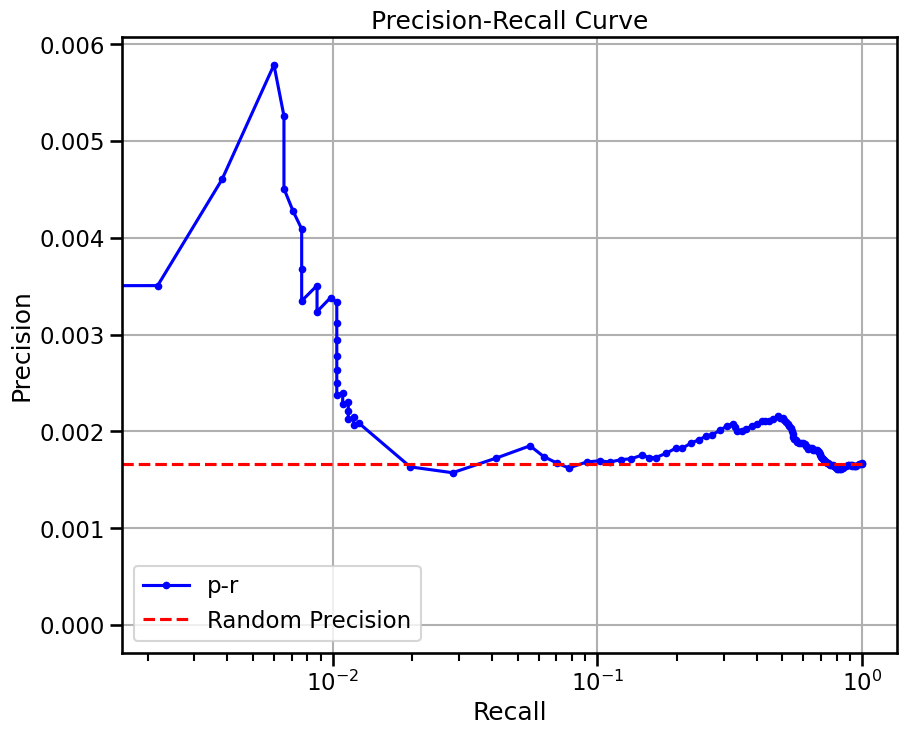

base enrichment


Top central genes: []


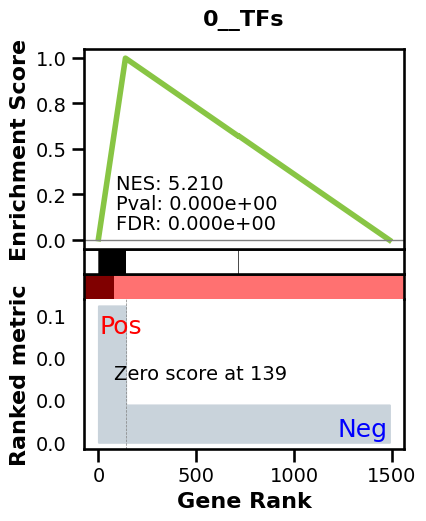

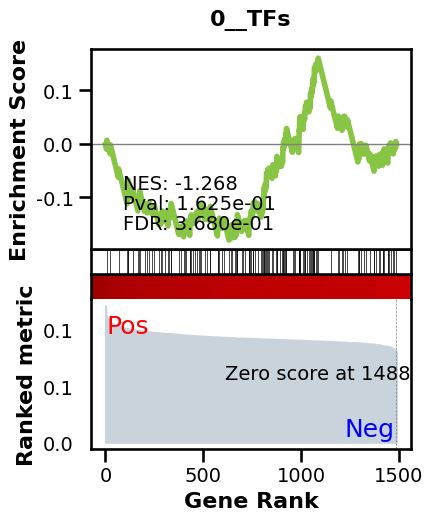

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 1050 genes
intersection pct: 0.7051712558764271
precision:  0.007893462469733657 
recall:  0.5332606324972737 
random precision: 0.0016650778519224658



  0%|          | 0/128 [00:00<?, ?it/s]


 62%|██████▏   | 79/128 [00:00<00:00, 786.48it/s]


100%|██████████| 128/128 [00:00<00:00, 785.20it/s]

Average Precision (AP):  0.005930839194608272
Area Under Precision-Recall Curve (AUPRC):  0.005362675221566701
EPR: 7.013714762749512


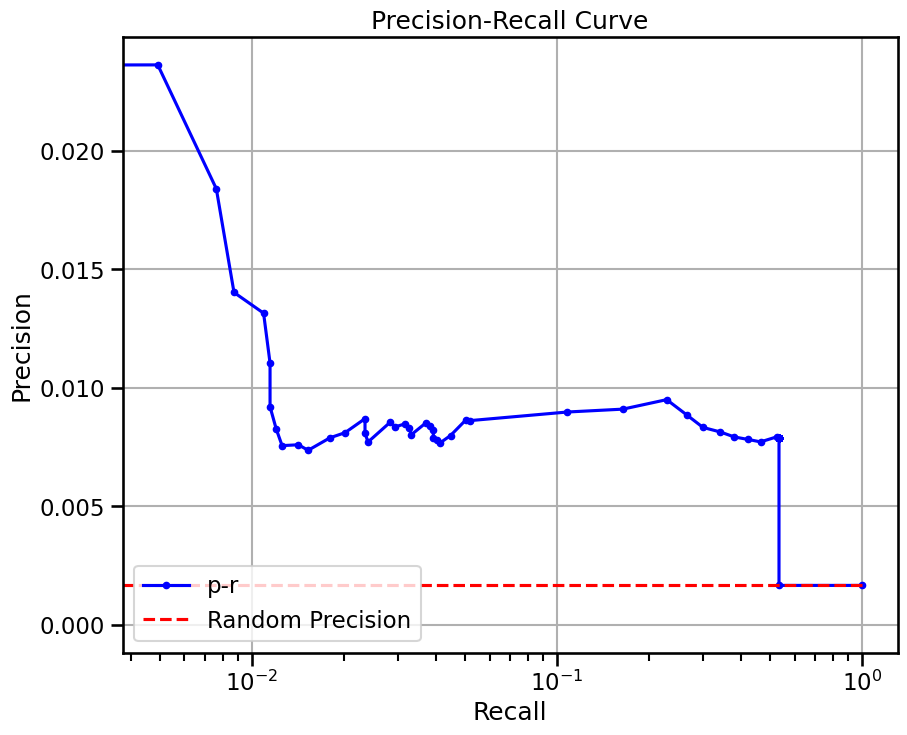

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...



  0%|          | 0/19 [00:00<?, ?it/s]


  5%|▌         | 1/19 [00:00<00:08,  2.09it/s]


 11%|█         | 2/19 [00:00<00:08,  2.08it/s]


 16%|█▌        | 3/19 [00:01<00:07,  2.09it/s]


 21%|██        | 4/19 [00:01<00:07,  2.08it/s]


 26%|██▋       | 5/19 [00:02<00:06,  2.08it/s]


 32%|███▏      | 6/19 [00:02<00:06,  2.08it/s]


 37%|███▋      | 7/19 [00:03<00:05,  2.09it/s]


 42%|████▏     | 8/19 [00:03<00:05,  2.10it/s]


 47%|████▋     | 9/19 [00:04<00:04,  2.10it/s]


 53%|█████▎    | 10/19 [00:04<00:04,  2.10it/s]


 58%|█████▊    | 11/19 [00:05<00:03,  2.10it/s]


 63%|██████▎   | 12/19 [00:05<00:03,  2.12it/s]


 68%|██████▊   | 13/19 [00:06<00:02,  2.09it/s]


 74%|███████▎  | 14/19 [00:06<00:02,  2.10it/s]


 79%|███████▉  | 15/19 [00:07<00:01,  2.09it/s]


 84%|████████▍ | 16/19 [00:07<00:01,  2.09it/s]


 89%|████████▉ | 17/19 [00:08<00:00,  2.09it/s]


 95%|█████████▍| 18/19 [00:08<00:00,  2.09it/s]


100%|██████████| 19/19 [00:08<00:00,  2.46it/s]


100%|██████████| 19/19 [00:08<00:00,  2.15it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


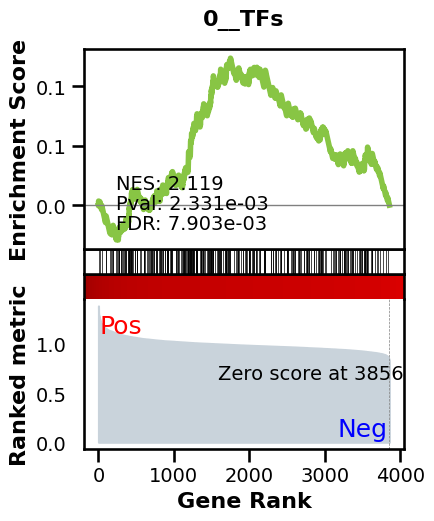

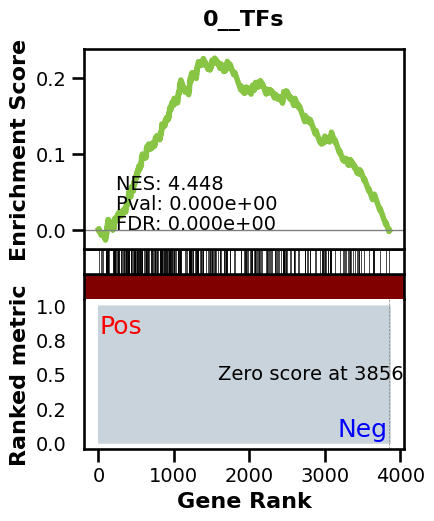

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2816 genes
intersection pct: 0.7301011148561057
precision:  0.0015420204351756198 
recall:  1.0 
random precision: 0.0015425682221863394



  0%|          | 0/128 [00:00<?, ?it/s]


  7%|▋         | 9/128 [00:00<00:01, 85.51it/s]


 14%|█▍        | 18/128 [00:00<00:01, 86.65it/s]


 21%|██        | 27/128 [00:00<00:01, 87.02it/s]


 28%|██▊       | 36/128 [00:00<00:01, 87.31it/s]


 35%|███▌      | 45/128 [00:00<00:00, 87.14it/s]


 42%|████▏     | 54/128 [00:00<00:00, 86.88it/s]


 49%|████▉     | 63/128 [00:00<00:00, 86.63it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 86.76it/s]


 63%|██████▎   | 81/128 [00:00<00:00, 86.73it/s]


 70%|███████   | 90/128 [00:01<00:00, 87.08it/s]


 77%|███████▋  | 99/128 [00:01<00:00, 87.01it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 87.24it/s]


 91%|█████████▏| 117/128 [00:01<00:00, 87.46it/s]


 98%|█████████▊| 126/128 [00:01<00:00, 87.47it/s]


100%|██████████| 128/128 [00:01<00:00, 87.04it/s]

Average Precision (AP):  0.0017536620732148788
Area Under Precision-Recall Curve (AUPRC):  0.0017526982901651356
EPR: 1.700145249758482


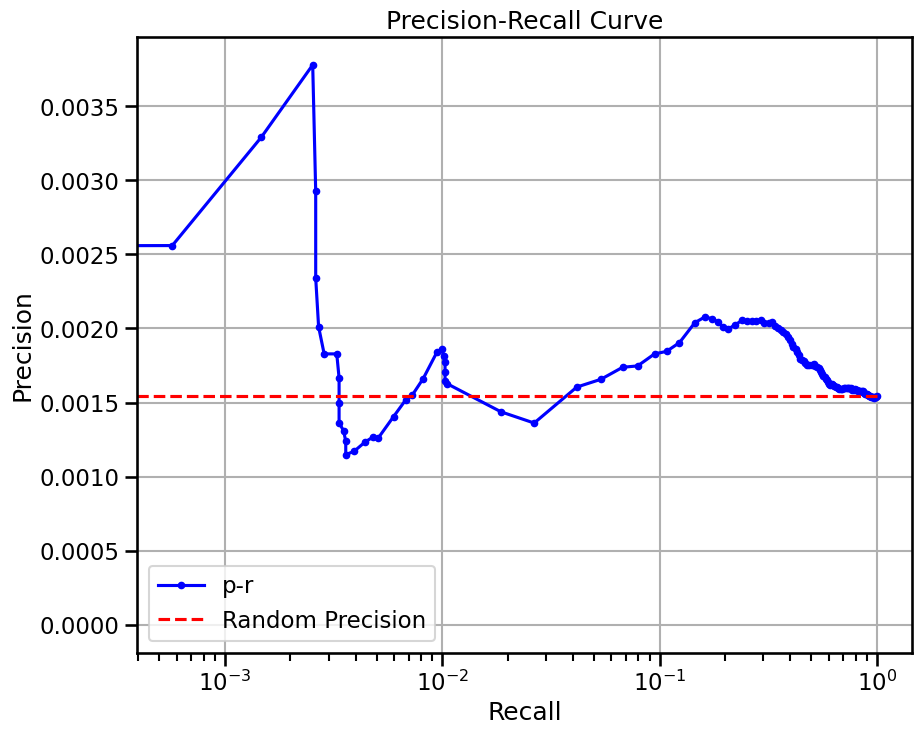

base enrichment


Top central genes: []


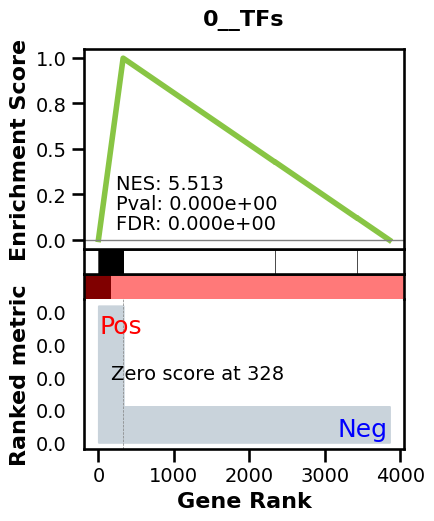

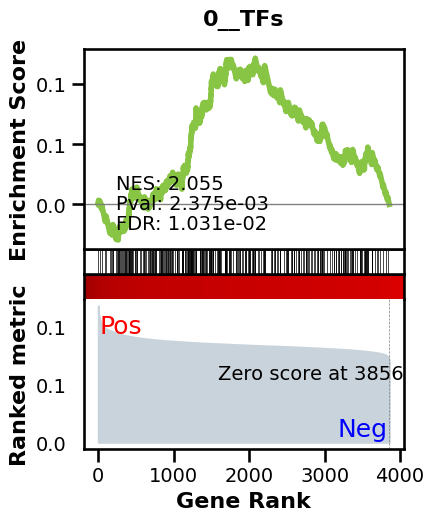

_________________________________________
TF specific enrichment


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2816 genes
intersection pct: 0.7301011148561057
precision:  0.007256722836239103 
recall:  0.4879784102060844 
random precision: 0.0015425682221863394



  0%|          | 0/128 [00:00<?, ?it/s]


  7%|▋         | 9/128 [00:00<00:01, 88.48it/s]


 14%|█▍        | 18/128 [00:00<00:01, 88.42it/s]


 21%|██        | 27/128 [00:00<00:01, 88.67it/s]


 28%|██▊       | 36/128 [00:00<00:01, 88.81it/s]


 35%|███▌      | 45/128 [00:00<00:00, 88.69it/s]


 42%|████▏     | 54/128 [00:00<00:00, 88.75it/s]


 49%|████▉     | 63/128 [00:00<00:00, 88.83it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 88.26it/s]


 63%|██████▎   | 81/128 [00:00<00:00, 88.29it/s]


 70%|███████   | 90/128 [00:01<00:00, 88.24it/s]


 77%|███████▋  | 99/128 [00:01<00:00, 88.26it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 88.35it/s]


 91%|█████████▏| 117/128 [00:01<00:00, 88.52it/s]


 98%|█████████▊| 126/128 [00:01<00:00, 88.71it/s]


100%|██████████| 128/128 [00:01<00:00, 88.48it/s]

Average Precision (AP):  0.005584802153287764
Area Under Precision-Recall Curve (AUPRC):  0.0051350753246851575
EPR: 5.045383226679041


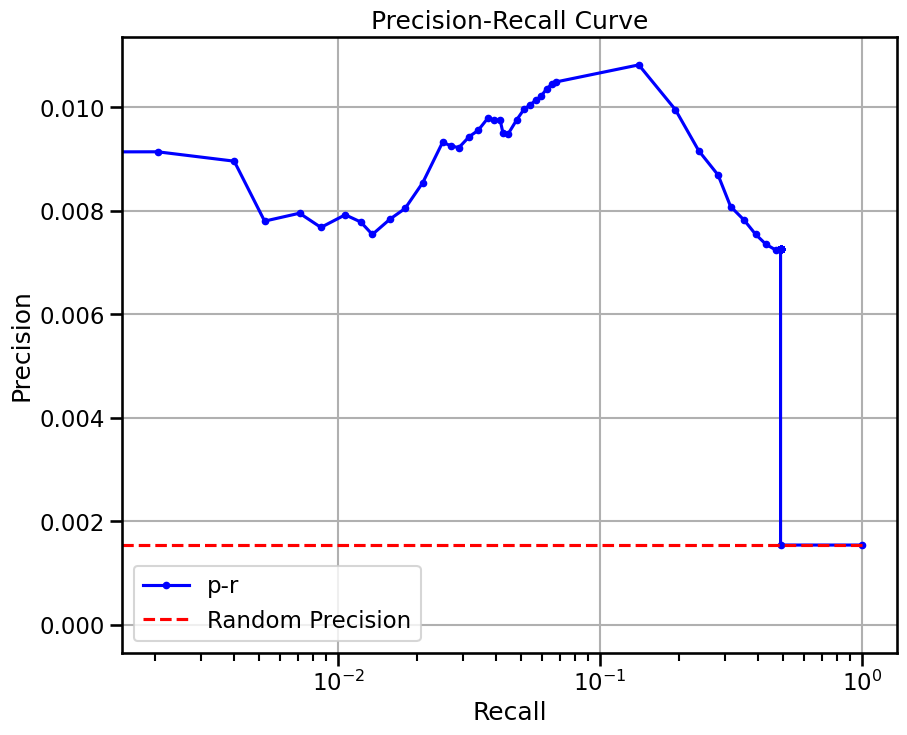

scGPT - INFO - Filtering genes by counts ...


scGPT - INFO - Normalizing total counts ...


scGPT - INFO - Log1p transforming ...


scGPT - INFO - Binning data ...


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.


scGPT - WARNING - The input data contains all zero rows. Please make sure this is expected. You can use the `filter_cell_by_counts` arg to filter out all zero rows.



  0%|          | 0/103 [00:00<?, ?it/s]


  7%|▋         | 7/103 [00:00<00:01, 61.41it/s]


 14%|█▎        | 14/103 [00:00<00:01, 63.89it/s]


 20%|██        | 21/103 [00:00<00:01, 64.88it/s]


 27%|██▋       | 28/103 [00:00<00:01, 65.24it/s]


 34%|███▍      | 35/103 [00:00<00:01, 65.26it/s]


 41%|████      | 42/103 [00:00<00:00, 65.53it/s]


 48%|████▊     | 49/103 [00:00<00:00, 65.73it/s]


 54%|█████▍    | 56/103 [00:00<00:00, 64.96it/s]


 61%|██████    | 63/103 [00:00<00:00, 65.23it/s]


 68%|██████▊   | 70/103 [00:01<00:00, 65.48it/s]


 75%|███████▍  | 77/103 [00:01<00:00, 65.60it/s]


 82%|████████▏ | 84/103 [00:01<00:00, 65.68it/s]


 88%|████████▊ | 91/103 [00:01<00:00, 65.69it/s]


 95%|█████████▌| 98/103 [00:01<00:00, 65.80it/s]


100%|██████████| 103/103 [00:01<00:00, 65.59it/s]

base enrichment


Top central genes: []
The DataFrame contains only the same values.


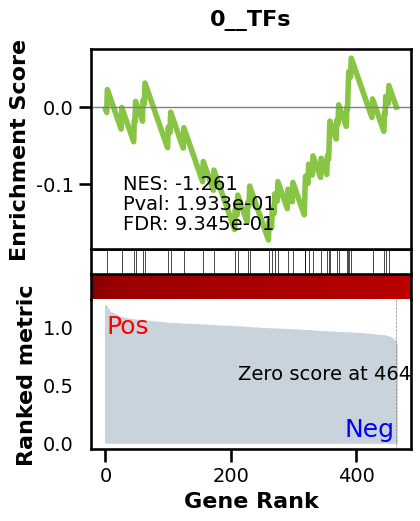

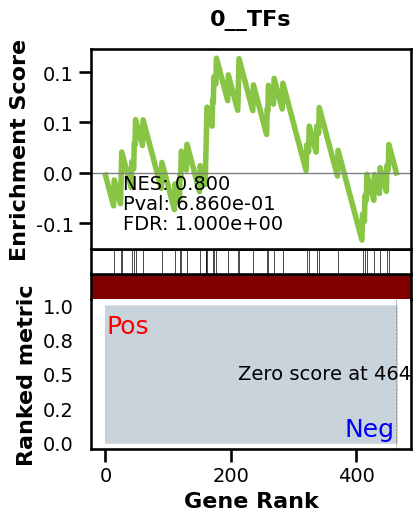

_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 335 genes
intersection pct: 0.7204301075268817
precision:  0.00269993316997104 
recall:  1.0 
random precision: 0.0027080168022164627



  0%|          | 0/128 [00:00<?, ?it/s]


100%|██████████| 128/128 [00:00<00:00, 6488.41it/s]

Average Precision (AP):  0.002595939208648345
Area Under Precision-Recall Curve (AUPRC):  0.0025624837698168396
EPR: 1.2201767466339195


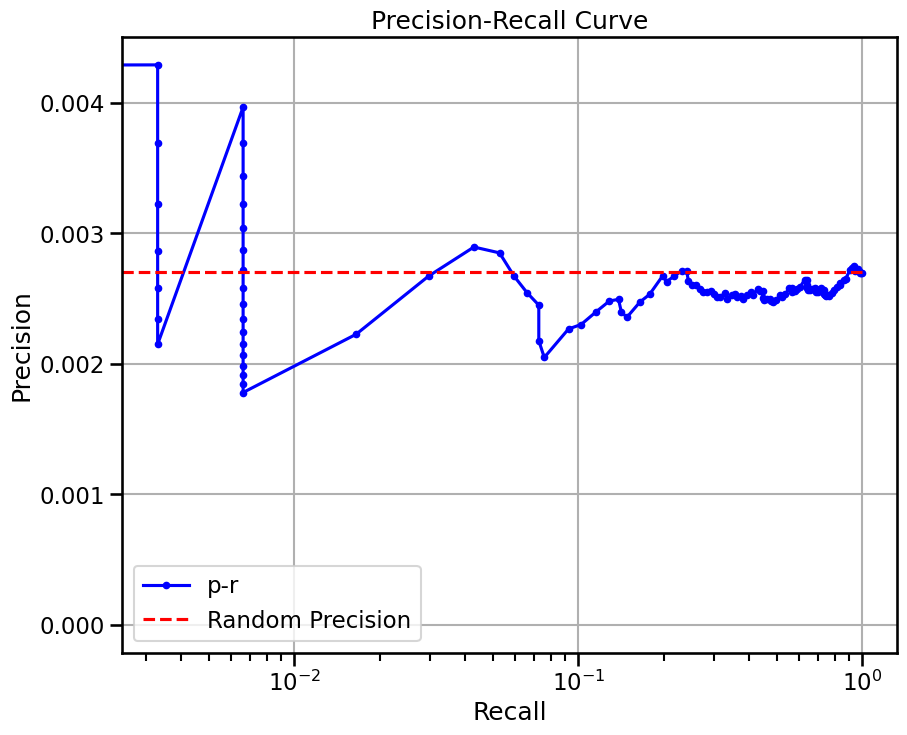

base enrichment
Top central genes: []


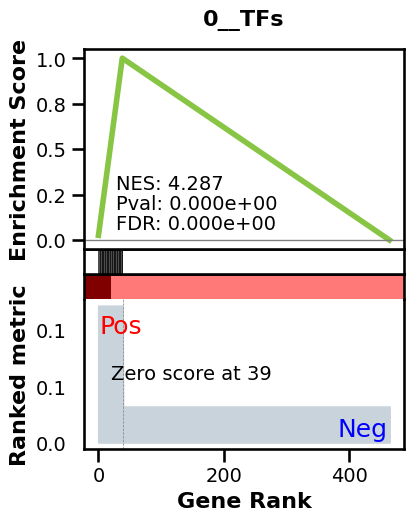

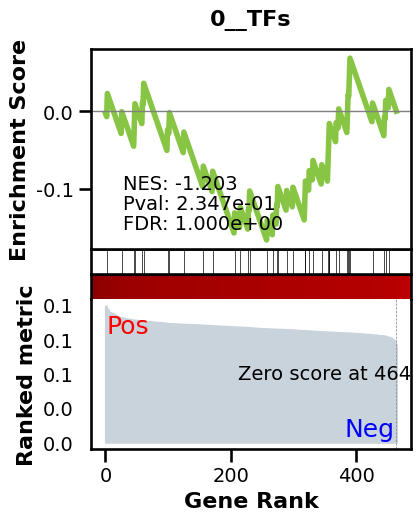

2024-07-15 20:54:35,233 [ERROR] No gene sets passed through filtering condition !!! 
Hint 1: Try to lower min_size or increase max_size !
Hint 2: Check gene symbols are identifiable to your gmt input.
Hint 3: Gene symbols curated in Enrichr web services are all upcases.



2024-07-15 20:54:35,234 [ERROR] The first entry of your gene_sets (gmt) look like this : { 0__TFs: [AC008770, AC023509, AC092835, AC138696, ADNP, ADNP2, AEBP1, AEBP2, AHCTF1, AHDC1, AHR, AHRR, AIRE, AKAP8, AKAP8L, AKNA, ALX1, ALX3, ALX4, ANHX, ANKZF1, AR, ARGFX, ARHGAP35, ARID2, ARID3A, ARID3B, ARID3C, ARID5A, ARID5B, ARNT, ARNT2, ARNTL, ARNTL2, ARX, ASCL1, ASCL2, ASCL3, ASCL4, ASCL5, ASH1L, ATF1, ATF2, ATF3, ATF4, ATF5, ATF6, ATF6B, ATF7, ATMIN, ATOH1, ATOH7, ATOH8, BACH1, BACH2, BARHL1, BARHL2, BARX1, BARX2, BATF, BATF2, BATF3, BAZ2A, BAZ2B, BBX, BCL11A, BCL11B, BCL6, BCL6B, BHLHA15, BHLHA9, BHLHE22, BHLHE23, BHLHE40, BHLHE41, BNC1, BNC2, BORCS8-MEF2B, BPTF, BRF2, BSX, C11orf95, CAMTA1, CAMTA2, CARF, CASZ1, CBX2, CC2D1A, CCDC169-SOHLH2, CCDC17, CDC5L, CDX1, CDX2, CDX4, CEBPA, CEBPB, CEBPD, CEBPE, CEBPG, CEBPZ, CENPA, CENPB, CENPBD1, CENPS, CENPT, CENPX, CGGBP1, CHAMP1, CHCHD3, CIC, CLOCK, CPEB1, CPXCR1, CREB1, CREB3, CREB3L1, CREB3L2, CREB3L3, CREB3L4, CREB5, CREBL2, CREBZF, CREM, CR

2024-07-15 20:54:35,234 [ERROR] The first 5 genes look like this : [ FOXF1, SOX18, EPAS1, TAL1, TEAD4 ]


raised a lookup error
_________________________________________
TF specific enrichment
found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath


intersection of 335 genes
intersection pct: 0.7204301075268817
precision:  0.016619604679306173 
recall:  0.6798679867986799 
random precision: 0.0027080168022164627



  0%|          | 0/128 [00:00<?, ?it/s]


100%|██████████| 128/128 [00:00<00:00, 6486.77it/s]

Average Precision (AP):  0.012917095831914405
Area Under Precision-Recall Curve (AUPRC):  0.012150620225859741
EPR: 6.265990270708526


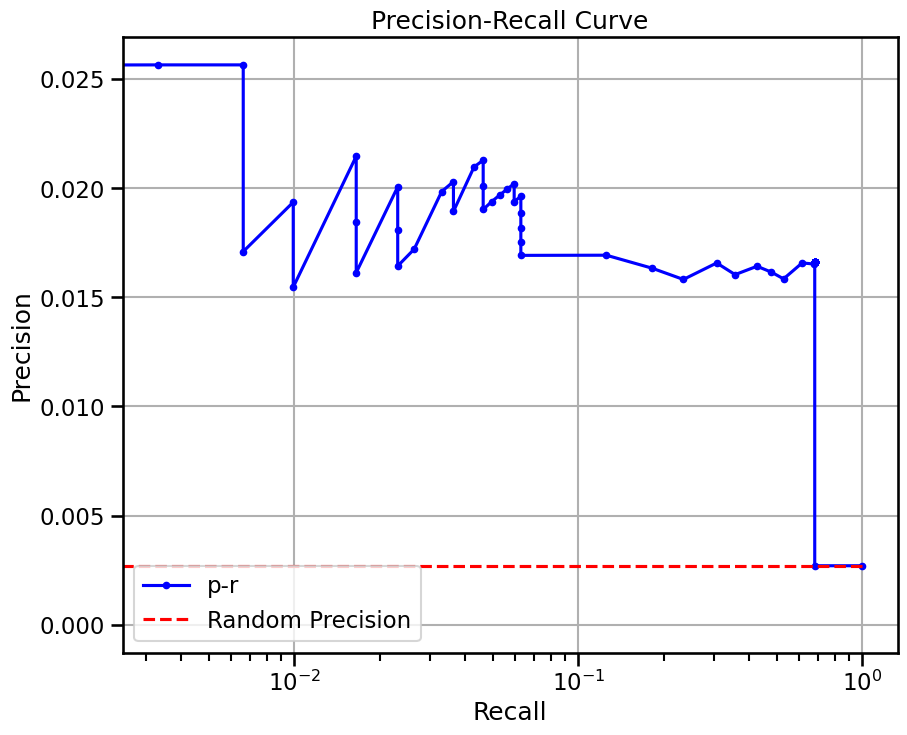

In [6]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype].tolist()
    to_use = [x for x in to_use if x in genes]
    to_use = to_use[:NUM_GENES]
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:MAXCELLS, adata.var.index.isin(
        to_use)]
    print(celltype, subadata.shape)
    subadata.var = subadata.var.set_index('feature_name')
    grn = generate_grn(model, vocab, subadata, batch_size = 10, num_attn_layers = 11)
    metrics["scGPT_"+celltype] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics['scGPT_tf_'+celltype] = BenGRN(grn).scprint_benchmark()

In [7]:
metrics

{'scGPT_kidney distal convoluted tubule epithelial cell': {'enriched_terms_Regulators': ['celltype.gmt__Distal tubule cells',
   'celltype.gmt__Enterocytes',
   'celltype.gmt__Connecting tubule cells',
   'celltype.gmt__Foveolar cells',
   'celltype.gmt__-intercalated cells (Collecting duct system)',
   'celltype.gmt__Hepatocytes',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Principal cells (Collecting duct system)',
   'celltype.gmt__Cone bipolar cells',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Alveolar macrophages',
   'celltype.gmt__Loop of Henle cells',
   'celltype.gmt__Melanocytes',
   'celltype.gmt__Acinar cells',
   'celltype.gmt__Kupffer cells',
   'celltype.gmt__Oligodendrocytes',
   'celltype.gmt__Proximal tubule cells',
   'celltype.gmt__Ductal cells',
   'celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Pulmonary alveolar type I cells'],
  'TF_enr': False,
  'enriched_terms_Targets': ['celltype.gmt__Distal tubule cells',
   'celltype.gmt__Ente

In [8]:
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
False

True

In [9]:
import pandas as pd

In [10]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,kidney distal convoluted tubule epithelial cell,0.418024,0.001125,0.001062,0.0,False,False
1,kidney distal convoluted tubule epithelial cell,5.492820,0.002397,0.001062,0.0,True,True
2,kidney loop of Henle thick ascending limb epit...,1.601299,0.001359,0.001212,0.0,True,False
3,kidney loop of Henle thick ascending limb epit...,7.504324,0.003709,0.001212,0.0,True,True
4,kidney collecting duct principal cell,0.667388,0.001621,0.001362,0.0,True,False
5,kidney collecting duct principal cell,8.956276,0.004798,0.001362,0.0,True,True
6,blood vessel smooth muscle cell,1.877086,0.001949,0.001771,0.0,True,False
7,blood vessel smooth muscle cell,6.532609,0.005903,0.001771,0.0,True,True
8,podocyte,1.540324,0.001728,0.001518,0.0,True,False
9,podocyte,7.603643,0.005567,0.001518,0.0,True,True
